# Data Project 1: Many Body Problem
In this data project, we will be exploring the long-term dynamical stability of satellites in a three-body system, with the *Jupiter trojans* as our test case. To do this, we will run some simple numerical simulations that evolve the positions and velocities of gravitationally interacting objects for three bodies orbiting in one plane (i.e. restricted to two dimensions). The code advances each particle according to its equation of motion, integrating it's future positions and velocities using a Runge-Kutta scheme.  


The code for initializing these simulations is below:

> run it once, but do not alter any of the code within the cell below.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

class State:
    """ a container to hold a single star's position """

    def __init__(self, x, y, u, v):

        self.x = x
        self.y = y
        self.u = u
        self.v = v

    def __add__(self, other):
        return State(self.x + other.x, self.y + other.y,
                     self.u + other.u, self.v + other.v)

    def __sub__(self, other):
        return State(self.x - other.x, self.y - other.y,
                     self.u - other.u, self.v - other.v)

    def __mul__(self, other):
        return State(other * self.x, other * self.y,
                     other * self.u, other * self.v)

    def __rmul__(self, other):
        return self.__mul__(other)

    def __str__(self):
        return f"{self.x:10.6f} {self.y:10.6f}{self.u:10.6f} {self.v:10.6f}"


class ThreeBody:
    """ model the gravitational interaction of three stars """

    def __init__(self, d0,d1,d2, SMALL=1.e-30):
        """ pos is a tuple of x-y coords of the stars """

        self.G = 1  # dimensionless units

        self.bodies = [d0,d1,d2]

        star0 = State(d0['p0'][0], d0['p0'][1], d0['u0'][0], d0['u0'][1])
        star1 = State(d1['p0'][0], d1['p0'][1], d1['u0'][0], d1['u0'][1])
        star2 = State(d2['p0'][0], d2['p0'][1], d2['u0'][0], d2['u0'][1])

        # this history will be stored in a list of tuples, such that
        # stars[n][istar] is star istar and timestep n

        self.stars = [(star0, star1, star2)]

        self.M = np.array([d0['m'], d1['m'], d2['m']])

        self.SMALL = SMALL

        self.time = [0.0]

    def npts(self):
        """ return the number of integration points """
        return len(self.time)

    def center_of_mass(self, n):
        """return the center of mass of the system at time n"""

        Mtot = np.sum(self.M)

        x_cm = 0.0
        y_cm = 0.0


        for mass, star in zip(self.M, self.stars[n]):
            x_cm += mass * star.x
            y_cm += mass * star.y


        x_cm /= Mtot
        y_cm /= Mtot


        return x_cm, y_cm

    def energy(self, n):
        """return the energy of the system at time n """

        # kinetic energy
        KE = [0.5 * self.M[i] * (self.stars[n][i].u**2 +
                                 self.stars[n][i].v**2 )
              for i in range(len(self.M))]

        # potential energy -- we need all pairs, but order doesn't matter

        PE = [-self.G * self.M[i] * self.M[j] /
              np.sqrt((self.stars[n][i].x - self.stars[n][j].x)**2 +
                      (self.stars[n][i].y - self.stars[n][j].y)**2 )
              for i in range(len(self.M)) for j in range(len(self.M)) if i > j]

        return sum(KE) + sum(PE)

    def rhs(self, star_states):
        """ here, star states is (State, State, ...) """

        ydots = []

        for istar in range(len(self.M)):

            # compute the space derivatives

            dxdt = star_states[istar].u
            dydt = star_states[istar].v

            # compute the velocity derivatives
            dudt = 0.0
            dvdt = 0.0

            for jstar in range(len(self.M)):
                if istar == jstar:
                    continue
                else:
                    dx = star_states[jstar].x - star_states[istar].x
                    dy = star_states[jstar].y - star_states[istar].y

                    r = np.sqrt(dx**2 + dy**2 ) + self.SMALL

                    dudt += self.G * self.M[jstar] * dx / r**3
                    dvdt += self.G * self.M[jstar] * dy / r**3

            ydots.append(State(dxdt, dydt, dudt, dvdt))

        return ydots


    def single_step(self, state_old, dt):
        """ take a single RK-4 timestep from t to t+dt for the system
        ydot = rhs """

        ydot1 = self.rhs(state_old)

        state_temp = [state_old[istar] + 0.5 * dt * ydot1[istar]
                      for istar in range(len(self.M))]
        ydot2 = self.rhs(state_temp)

        state_temp = [state_old[istar] + 0.5 * dt * ydot2[istar]
                      for istar in range(len(self.M))]
        ydot3 = self.rhs(state_temp)

        state_temp = [state_old[istar] + dt * ydot3[istar]
                      for istar in range(len(self.M))]
        ydot4 = self.rhs(state_temp)

        state_new = [state_old[istar] + (dt/6.0) * (ydot1[istar] + 2.0*ydot2[istar] +
                                                    2.0*ydot3[istar] + ydot4[istar])
                     for istar in range(len(self.M))]

        return state_new

    def integrate(self, dt, err, tmax):
        """ integrate the equations of motion using 4th order R-K
            method with an adaptive stepsize, to try to achieve the
            relative error err.  dt here is the initial timestep

            if err < 0, then we don't do adaptive stepping, but rather
            we always walk at the input dt
            """

        # safety parameters
        S1 = 0.9
        S2 = 4.0

        # initial conditions
        t = 0.0

        # start with the old timestep
        dt_new = dt

        n_reset = 0

        while t < tmax:

            state_old = self.stars[-1]

            # adaptive stepping iteration loop -- keep trying to take
            # a step until we achieve our desired error
            rel_error = 1.e10

            n_try = 0
            while rel_error > err:
                dt = dt_new
                if t + dt > tmax:
                    dt = tmax-t

                # take 2 half steps
                state_tmp = self.single_step(state_old, 0.5*dt)
                state_new = self.single_step(state_tmp, 0.5*dt)

                # now take just a single step to cover dt
                state_single = self.single_step(state_old, dt)

                # state_new should be more accurate than state_single,
                # since it used smaller steps.

                # estimate the relative error now
                pos_err = max([max(abs((state_new[istar].x - state_single[istar].x) / state_single[istar].x),
                                   abs((state_new[istar].y - state_single[istar].y) / state_single[istar].y))
                               for istar in range(len(self.M))])

                vel_err = max([max((abs(state_new[istar].u - state_single[istar].u) / state_single[istar].u),
                                   (abs(state_new[istar].v - state_single[istar].v) / state_single[istar].v))
                               for istar in range(len(self.M))])

                rel_error = max(pos_err, vel_err)

                # adaptive timestep algorithm from Garcia (Eqs. 3.30
                # and 3.31)
                dt_est = dt * abs(err / rel_error)**0.2
                dt_new = min(max(S1*dt_est, dt/S2), S2*dt)

                n_try += 1

            if n_try > 1:
                # n_try = 1 if we took only a single try at the step
                n_reset += (n_try-1)

            # successful step
            t += dt

            # set for the next step
            self.time.append(t)
            self.stars.append(state_new)

        #position of the center of mass over time
        x_cm = np.array([(self.center_of_mass(n))[0] for n in np.arange(len(self.time))])
        y_cm = np.array([(self.center_of_mass(n))[1] for n in np.arange(len(self.time))])

        #assign output values to dictionary
        for istar,body in zip(range(len(self.M)),self.bodies):
            body['x'] = np.array([star[istar].x for star in self.stars])
            body['y'] = np.array([star[istar].y for star in self.stars])
            body['x_cm'] = body['x'] - x_cm
            body['y_cm'] = body['y'] - y_cm
            body['vx'] = np.array([star[istar].u for star in self.stars])
            body['vy']= np.array([star[istar].v for star in self.stars])

        

    

The rest of the assignment has been scaffolded: there is existing code provided as an example and some functions have been pre-defined for your use with comments marking areas in which you should add your own inputs. Required regions for your input will have a ```# * HERE * #``` comment.  You may need to write additional code. You can choose to modify the existing code (as long as the final result can be run only from what is contained in your submitted notebook).

Cells that have text in them (markdown cells) can be double-clicked to edit. Be sure to answer the questions in the markdown cells by editing in your own answer.

*NOTE:*
Feel free to work collaboratively with other members of the class on the coding portions of this project. However, the **Questions** must be answered in your own words and reflect your own thinking.



## Part I: Modified Two-Body Problem

First, let's set up a system whose behavior we know to expect: the orbit of Jupiter around the Sun with simple initial conditions. The code requires the positions in x and y, the velocities in x and y, and the mass of each body in code units.

In the cell below:

> Define the function ```set_v``` that calculates the correct initial velocity for Jupiter around the Sun as a function of it's initial position.

> Set up the initial conditions for Jupiter


Feel free to use any of the convenience functions defined to help you.

In [2]:
# units: these are the code units
G = 1
M = 1 # Msun
L = 1 # au
T = 2*np.pi #2pi = 1 orbit = 1 yr
SMALL = 1E-32

# convenience functions for coordinate transforms between cylindrical and cartesian coordinates
def p_to_cart(r,phi):
    """ function that takes r and phi positions and returns them in x and y
    note: angles in radians"""
    return (r*np.cos(phi),r*np.sin(phi))

def p_to_cyl(x,y):
    """ function that takes x and y positions and returns in r and phi
    note: angles in radians
    """
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y,x)
    return (r,phi)

def v_to_cart(vtot,phi):
    """function to take the projection of an azimuthal velocity to it's cartesian components
    note: python takes angles in radians"""
    return (-vtot*np.sin(phi),vtot*np.cos(phi))

def p_rotate(p,phase):
    """function that takes a position in cartesian coordinates advanced by some phase angle and returns the new cartesian coordinates
    note: angles in radians"""
    x,y = p
    r,phi0 = p_to_cyl(x,y)
    return p_to_cart(r,phi0+phase)

def p_perturb(p,dr):
    """function that takes a position in cartesian coordinates and shifts it radially by some amount dr and returns the new cartesian coordinates"""
    x,y = p
    r,phi0 = p_to_cyl(x,y)
    return p_to_cart(r+dr,phi0)


def set_v(p0,m0=M):
    """function that takes a tuple initial position in cartesian coordinates, calculates and returns the cartesian velocities in x and y
    p0 = (x,y):  the initial position in au
    m0 = 1 : mass in solar masses """
    x,y = p0
    vx,vy = (0,0)
    r, phi = p_to_cyl(x,y)
    v = np.sqrt(G*m0/r)
    vx,vy = v_to_cart(v, phi)
    v_at_pos = (vx,vy)
    return v_at_pos

# Initial conditions for the Sun and Jupiter 
# The Sun
p_s = (0,0) # position
v_s = (0,0) # velocity
m_s = M # mass

# Set your values * HERE * (replace 1's) before running simulation
# Jupiter
p_j = p_to_cart(5.2, 0) # position
v_j = set_v(p_j) # velocity
m_j = 1/1000 # mass



Now, if you've set your initial conditions above, you'll run the simulation in the following cell. The ```ThreeBody``` object takes three dictionaries, one for each body, of the initial conditions as input. Running the simulation integrates them forward in time, with the relative error maximum, initial timestep, and end time of the simulation as parameters. 

For this part, you don't need to change anything in the code below. It should take no longer than a few seconds to run a simulation. In the code below, after the simulation is complete, it's raw outputs are stored as attributes of the ```sim``` object. For convenience, the basic trajectories: positions and velocities of each object, are then stored in the dictionaries that were input.

> Run the simulation in the code below

In [3]:
# Initial Conditions defined, change values in cell above, not here
Sun = {'m':m_s,'p0':p_s,'u0':v_s,'color':'orange','name':'sun'}
Jupiter = {'m':m_j, 'p0':p_j,'u0':v_j,'color':'maroon','name':'jupiter'}
Third = {'m':SMALL, 'p0':p_j,'u0':v_j,'color':'C0','name':'third'} #dummy input for 3rd body of insignificant mass

# length of one orbit for Jupiter in code units
t_orb = T*(p_to_cyl(*p_j)[0])**(3./2.)

#setup and run a simulation
sim = ThreeBody(Sun,Jupiter,Third)
tmax = t_orb*10
err = 1e-6
dt_i = 1e-8
sim.integrate(err, dt_i, tmax) #runs the simulation
print('Simulation Done!')


time_orb = np.array(sim.time)/t_orb # time in number of Jupiter orbits

bodies = [Sun,Jupiter,Third] #dictionaries for each object 
for body in bodies:
    print(body.keys()) #print what values are stored by each key
    # You can use these keys to access the output information for each body in the simulation. For example, to get the x position of the Sun over time, x = Sun['x']


Simulation Done!
dict_keys(['m', 'p0', 'u0', 'color', 'name', 'x', 'y', 'x_cm', 'y_cm', 'vx', 'vy'])
dict_keys(['m', 'p0', 'u0', 'color', 'name', 'x', 'y', 'x_cm', 'y_cm', 'vx', 'vy'])
dict_keys(['m', 'p0', 'u0', 'color', 'name', 'x', 'y', 'x_cm', 'y_cm', 'vx', 'vy'])


Now, let's plot the results! In each of the three subplots, we'll plot the results in terms of three frames:
+ the Lab frame: the direct simulation output results.
+ the CoM frame: the center-of-mass frame using the center of mass positions calculated in the simulation
+ the rotating frame: frame co-rotating with Jupiter with respect to the center of mass

Example code to access and plot these quantities is included here for your use, feel free to make modifications.

> Run the plotting code in the cell below to make a plot of Jupiter's trajectory in the three frames above.

Text(0.5, 0.98, 'position of Sun and Jupiter over 10 orbits')

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


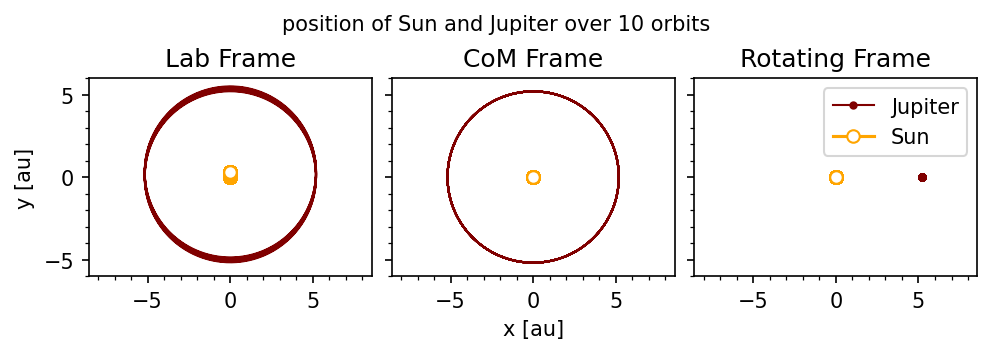

In [4]:
f,(a1,a2,a3) = plt.subplots(1,3,constrained_layout=True,dpi=150,sharey=True)
f.set_size_inches(6.5,2.25)

#Lab Frame
a1.plot(Jupiter['x'],Jupiter['y'],lw=1,color=Jupiter['color'])
a1.plot(Sun['x'],Sun['y'],color=Sun['color'],ls=None,marker='o',mfc='white')

#CoM Frame
a2.plot(Jupiter['x_cm'],Jupiter['y_cm'],lw=1,color=Jupiter['color'])
a2.plot(Sun['x_cm'],Sun['y_cm'],color=Sun['color'],ls=None,marker='o',mfc='white')

# In (Jupiter's) Rotating Frame w.r.t to the CoM
rj,phij = p_to_cyl(Jupiter['x_cm'],Jupiter['y_cm'])
J_frame = p_rotate((Jupiter['x_cm'],Jupiter['y_cm']),-phij)
S_frame = p_rotate((Sun['x_cm'],Sun['y_cm']),-phij)
a3.plot(*J_frame,lw=1,color=Jupiter['color'],ls=None,marker='.',label="Jupiter")
a3.plot(*S_frame,color=Sun['color'],ls=None,marker='o',mfc='white',label="Sun")

for a in (a1,a2,a3):
    a.axis('equal')
    a.xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
    a.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    a.yaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
    a.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    a.set_xlim(-6,6)
    a.set_ylim(-6,6)

a1.set_ylabel('y [au]')
a2.set_xlabel('x [au]')
a1.set_title('Lab Frame')
a2.set_title('CoM Frame')
a3.set_title('Rotating Frame')
a3.legend()
f.suptitle('position of Sun and Jupiter over 10 orbits',fontsize=10)



### Questions
Based on the calculations in part I, write your answer to the following questions in the space provided.

>Q1: For this simple two-body problem, what are the expectations of the trajectories for the:  

>a) Lab frame  

In the lab frame, both the Sun and Jupiter would orbit around the center of mass of the system. Thus both bodies appear to be wavering in a circular orbital path, with Jupiters path being much larger than the Sun's slight change in position. 

>b) Center of mass frame  

In the center of mass frame, the plotted values of the Sun and Jupiter are with respect to the center of mass of the system, (which is at the origin on the graph), based on current body placement. $body['x_cm'] = body['x'] - x_cm$. Thus, the Sun appears to remain fixed in the center of the system, while Jupiter orbits in a steady circular path of 5.2AU around the center, the Sun. 

>c) Rotating frame  

In the rotating frame, as we are co-rotating with Jupiter, Jupiter now appears as a stationary fixed point at 5.2AU away from the Sun, that also remains a stationary point in the center. 


>Q2: If the Sun's initial velocity and position are set to 0, the position of the Sun in the Lab frame will not remain centered over time. Why does this happen? Hint: consider the behavior in the center of mass frame.   

Referencing Kepler's first law "the two bodies move along elliptical paths, with one focus of each ellipse located at the center of mass of the system,"(Lissauer 28). Even though the Sun is intially at rest and centered at 0, the position and mass of Jupiter, makes the center of mass of the system not at the placement of the Sun, but rather slightly off-center. Obeying the laws of planetary motion, both bodies would therefore rotate about the barycenter. As Jupiter has an intial velocity, the gravitational attraction between them causes the Sun to appear to 'wobble' as its orbital is very small. 

## Part II: Constrained Three-Body Problem
Now that you've gotten the basic functionality down, let's move onto the 3-body problem! This time, you'll need to set the initial conditions for the Sun, Jupiter, and a test mass Satellite (Third) to reproduce the orbit criteria in each part.   
(You can use your initial conditions for the Sun and Jupiter from part I.)

Background Reading: L&dP Section 2.2




### a. Steady-State Libration
For the satellite, you'll want to find the initial conditions for a steady-state orbit about a suitable Lagrange point.   
This will depend on finding an initial position and corresponding velocity that places the Third body into a tadpole orbit.  

(This might take some experimentation.)
> Define the position of the Lagrange point you are using

> Define the initial conditions for a satellite (Third body) which has a stable tadpole orbit about a Lagrange point.

We'll want to compare distances in terms of a meaningful physical quality: the Hill Radius

> Define a function to calculate Jupiter's hill radius

In [5]:
def r_H(r, m): # your parameters * HERE *
    """function to calculate the Hill sphere"""
    # Your function * HERE * #
    hill = r * (m/(3*M))**(1/3)
    return hill

# Define the position of the Lagrange point here
p_Lpt = p_to_cart(5.2,np.pi/3) #dummy value, replace with your own

# Set initial conditions * HERE *
p_s = (0,0)
v_s = (0,0)
m_s = 1

p_j = p_to_cart(5.2, 0) # position
v_j = set_v(p_j) # velocity
m_j = 1/1000 # mass

# Dummy initial conditions, replace with your own!
p_3 = p_to_cart(5.1, np.pi/3)
v_3 = set_v(p_3)
m_3 = SMALL # the third body should be a 'test mass'



# Change parameters above, not here
Sun = {'m':m_s,'p0':p_s,'u0':v_s,'color':'orange','name':'sun'}
Jupiter = {'m':m_j, 'p0':p_j,'u0':v_j,'color':'maroon','name':'jupiter'}
Third = {'m':m_3, 'p0':p_3,'u0':v_3,'color':'violet','name':'third'}

#length of one orbit for Jupiter in code units
t_orb = T*(p_to_cyl(*p_j)[0])**(3./2.)

#setup and run a simulation
sim = ThreeBody(Sun,Jupiter,Third)
tmax = t_orb*30
err = 1e-8
dt_i = 1e-10
sim.integrate(err, dt_i, tmax)
print('Simulation Done!')
time_orb = np.array(sim.time)/t_orb # time in number of Jupiter orbits

Simulation Done!


Now we want to look at the orbit. Use the code below to:

> Plot the orbital positions over time in the CoM frame and the Rotating Frame

> Plot the radial distance from the CoM for the satellite and Jupiter over time in units of orbital times at Jupiter's location

> Indicate the bounds of Jupiter's Hill Sphere on the radial distance plot

Max:  5.3004996902079915
Min:  5.086606725353119
Width:  0.21389296485487286


5.086606725353119 12.473503406371668
Jupiter Stuff
Max:  5.194805194805195
Min:  5.184436322196995
Width:  0.01036887260819963
Hill:  0.36054786266233013
Hill Range:  0.7210957253246603


Text(0, 0.5, 'r [au]')

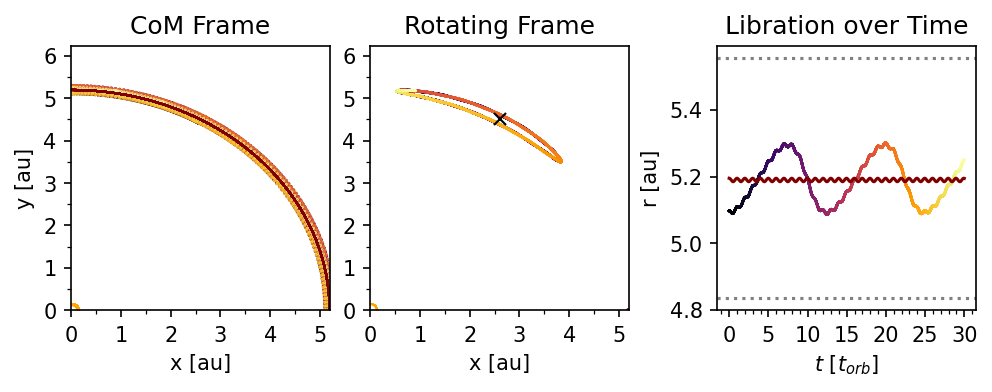

In [6]:
f,(a1,a2,a3) = plt.subplots(1,3,constrained_layout=True,dpi=150)
f.set_size_inches(6.5,2.5)

# CoM Frame
a1.set_title("CoM Frame")
a1.plot(Jupiter['x_cm'],Jupiter['y_cm'],lw=1,color=Jupiter['color'])
a1.plot(Sun['x_cm'],Sun['y_cm'],color=Sun['color'],ls=None,marker='o',mfc='white')
a1.scatter(Third['x_cm'],Third['y_cm'],c=time_orb,s=0.1,cmap='inferno') # colors map to orbital times
a1.set_ylabel('y [au]')

# In (Jupiter's) Rotating Frame w.r.t to the CoM
rj,phij = p_to_cyl(Jupiter['x_cm'],Jupiter['y_cm'])
J_frame = p_rotate((Jupiter['x_cm'],Jupiter['y_cm']),-phij)
S_frame = p_rotate((Sun['x_cm'],Sun['y_cm']),-phij)
T_frame = p_rotate((Third['x_cm'],Third['y_cm']),-phij)

a2.set_title('Rotating Frame')
a2.plot(*J_frame,lw=2,color=Jupiter['color'])
a2.plot(*S_frame,color=Sun['color'],ls=None,marker='o',mfc='white')
a2.scatter(*T_frame,c=time_orb,s=0.1,cmap='inferno')

#plot the location of the Lagrange point
a2.plot(*p_Lpt,marker='x',color='black')

for a in (a1,a2):
    #a.axis('equal')
    a.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    a.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
    a.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    a.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
    a.set_xlim(min(np.amin(T_frame[0]),0),max(np.amax(T_frame[0]),p_j[0]))
    a.set_ylim(min(np.amin(T_frame[1]),0),max(np.amax(T_frame[1])*1.2,p_Lpt[1]))
    a.set_xlabel('x [au]')

# Satellite + Jupiter radial location over time
r3, phi3 = p_to_cyl(Third['x_cm'],Third['y_cm'])
a3.plot(time_orb, rj,color=Jupiter['color'])
a3.scatter(time_orb, r3,c=time_orb,s=0.1,cmap='inferno')
print("Max: " , max(r3))
print("Min: " , min(r3))
print("Width: " , (max(r3) - min(r3)))
for i in range(0, len(r3)):
    if r3[i] == min(r3):
        print(r3[i], time_orb[i])

print("Jupiter Stuff")
print("Max: " , max(rj))
print("Min: " , min(rj))
print("Width: " , (max(rj) - min(rj)))

# plot the bounds of Jupiter's hill sphere * HERE *
r_Hill = r_H(5.2, m_j) # Calculate r_Hill * HERE *
a3.axhline(rj[0] + r_Hill, color='gray',ls='dotted')
a3.axhline(rj[0] - r_Hill, color='gray',ls='dotted')
print("Hill: " , r_Hill)
print("Hill Range: " , r_Hill * 2)

a3.set_xlabel(r'$t \ [t_{orb}]$')

a3.set_title('Libration over Time')
a3.xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
a3.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
a3.set_ylabel('r [au]')






### Questions

> Q1: Which Lagrange point does your satellite orbit?

My satellite orbits Lagrange point 4, L4, since it is $\pi/3$ ahead of Jupiter in orbit forming an equilateral triangle. 

> Q2: What is the radial width of your tadpole orbit? How does it compare to the Hill Sphere?

The radial width of my tadpole orbit is $R_{width} = R_{max} - R_{min} = 0.21 AU$. The Hill Sphere radius is 0.36 AU, so the tadpole orbit is within the Hill sphere range of 0.72 AU (4.84 AU to 5.56 AU), meaning that it is gravitationally influenced by Jupiter, and is able to liberate in the stable region around the Lagrange point. General tadpole libaration widths are proportional to $(m_2/m_1)^{1/2}r$ which is calculated to be about 0.16 AU which is close to my observed tadpole orbit width from chosen experimental values.


> Q3: What is the period of the tadpole orbit in Jupiter orbits? Do you observe any other periodicity? On what timescales? 

The period of the tabpole orbit in Jupiter orbits is roughly 12 Jupiter orbits. Another periodicity that is observed is on the timescale of about one Jupiter orbit. This is similar to the plot of Jupiters orbital distance and how it very slightly varies on its own orbit around the sun. Thus Jupiter's motion appears to influence the the shorter periodic varations that are observed in the tadpole orbits liberation period. 

> Q4 (Bonus): If you experiment with the initial conditions, what controls the azimuthal extent of the tadpole orbit you can achieve?

The azimuthal extent is controlled by how far the satellite is from the Lagrange point. In my inital simulation it was located at 5.1 AU, 60 degrees in polar coordinates, where L4 is 5.2 AU, 60 degrees. This produced an width of 0.21AU. Increasing the distance from the Lagrange point to 5.0 AU, 60 degrees, the width was 0.42 AU. However increasing the distance too much, formed a horseshoe orbit. If we are the decrease the distance then the liberation path becomes smaller. 

### b. Horseshoe Orbit
Here you'll want to apply the same principles but this time you want to place your satellite in a horseshoe orbit.

> Define the position of the Lagrange point you are using.

> Define the initial conditions for a satellite (Third body) which has a stable horseshoe orbit about a Lagrange point.

In [7]:
# Define the position of the Lagrange point here
p_Lpt = p_to_cart(5.2,np.pi) #dummy value replace with your own

# Set initial conditions * HERE *
p_s = (0,0)# copy from before
v_s = (0,0)
m_s = 1

p_j = p_to_cart(5.2, 0)
v_j = set_v(p_j) # velocity
m_j = 1/1000 

# Dummy initial conditions, replace with your own!
p_3 = p_to_cart(5.1, np.pi)
v_3 = set_v(p_3)
m_3 = SMALL # the third body should be a 'test mass'

Sun = {'m':m_s,'p0':p_s,'u0':v_s,'color':'orange','name':'sun'}
Jupiter = {'m':m_j, 'p0':p_j,'u0':v_j,'color':'maroon','name':'jupiter'}
Third = {'m':m_3, 'p0':p_3,'u0':v_3,'color':'C0','name':'third'}

#length of one orbit for Jupiter in years
t_orb = 2*np.pi*(5.2**1.5)

#setup and run a simulation
tb = ThreeBody(Sun,Jupiter,Third)
tmax = t_orb*50
err = 1e-6
dt_i = 1e-8
tb.integrate(err, dt_i, tmax)
print('Simulation Done!')
time_orb = np.array(tb.time)/t_orb




Simulation Done!


Now we want to look at the orbit agan. Use the code below to:

> Plot the orbital positions over time in the CoM frame and the Rotating Frame

> Plot the radial distance from the CoM for the satellite and Jupiter over time in units of orbital times at Jupiter's location

> Include the bounds of Jupiter's Hill Sphere

[26.45533557 26.45533557 26.45533557 ... 28.46908262 28.45414661
 28.44808307]
Max:  5.516177982458806
Min:  4.895938573027595
Width:  0.6202394094312105
Hill:  0.36054786266233013


Text(0, 0.5, 'r [au]')

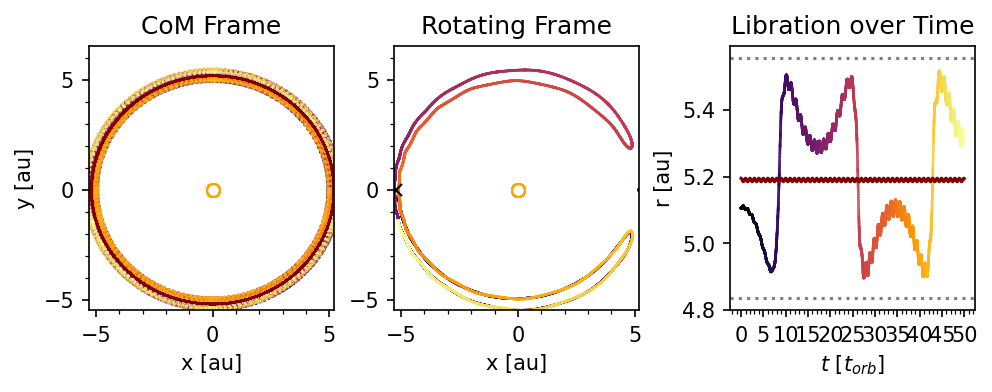

In [8]:
f,(a1,a2,a3) = plt.subplots(1,3,constrained_layout=True,dpi=150)
f.set_size_inches(6.5,2.5)

# CoM Frame
a1.set_title("CoM Frame")
a1.plot(Jupiter['x_cm'],Jupiter['y_cm'],lw=1,color=Jupiter['color'])
a1.plot(Sun['x_cm'],Sun['y_cm'],color=Sun['color'],ls=None,marker='o',mfc='white')
a1.scatter(Third['x_cm'],Third['y_cm'],c=time_orb,s=0.1,cmap='inferno') # colors map to orbital times
a1.set_ylabel('y [au]')

def Jacobi_Constant(x, y, m1, m2):
    r, phi = p_to_cyl(x, y)
    r1, phi2 = p_to_cyl(-m2/(m1 + m2), 0)
    r2, phi4 = p_to_cyl(m1/(m1 + m2), 0)
    cj = x**2 + y**2 + (2*m1/(r-r1)) + (2*m2/(r-r2)) - 0
    return cj

# In (Jupiter's) Rotating Frame w.r.t to the CoM
rj,phij = p_to_cyl(Jupiter['x_cm'],Jupiter['y_cm'])
J_frame = p_rotate((Jupiter['x_cm'],Jupiter['y_cm']),-phij)
S_frame = p_rotate((Sun['x_cm'],Sun['y_cm']),-phij)
T_frame = p_rotate((Third['x_cm'],Third['y_cm']),-phij)
JC_frame = Jacobi_Constant(T_frame[0], T_frame[1], m_s, m_j)
print(JC_frame)

a2.set_title('Rotating Frame')
a2.plot(*J_frame,lw=2,color=Jupiter['color'])
a2.plot(*S_frame,color=Sun['color'],ls=None,marker='o',mfc='white')
a2.scatter(*T_frame,c=time_orb,s=0.1,cmap='inferno')
#a2.contour(T_frame[0], T_frame[1], JC_frame)

#plot the location of the Lagrange point
a2.plot(*p_Lpt,marker='x',color='black')

for a in (a1,a2):
    #a.axis('equal')
    a.xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
    a.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    a.yaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
    a.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    a.set_xlim(min(np.amin(T_frame[0]),0),max(np.amax(T_frame[0]),p_j[0]))
    a.set_ylim(min(np.amin(T_frame[1]),0),max(np.amax(T_frame[1])*1.2,p_Lpt[1]))
    a.set_xlabel('x [au]')

# Satellite + Jupiter radial location over time
r3, phi3 = p_to_cyl(Third['x_cm'],Third['y_cm'])
a3.plot(time_orb, rj,color=Jupiter['color'])
a3.scatter(time_orb, r3,c=time_orb,s=0.1,cmap='inferno')
print("Max: " , max(r3))
print("Min: " , min(r3))
print("Width: " , (max(r3) - min(r3)))

# plot the bounds of Jupiter's hill sphere * HERE *
r_Hill = r_H(5.2, m_j) # calculate r_Hill * HERE *
a3.axhline(rj[0] + r_Hill, color='gray',ls='dotted')
a3.axhline(rj[0] - r_Hill, color='gray',ls='dotted')
print("Hill: " , r_Hill)

a3.set_xlabel(r'$t \ [t_{orb}]$')
a3.set_title('Libration over Time')
a3.xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
a3.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
a3.set_ylabel('r [au]')





### Questions

> Q1: What is the main difference between your initial conditions for a horseshoe orbit vs a tadpole orbit?

The main difference between my intial conditions for a horseshow orbit and a tadpole orbit is while in the tadpole orbit started near L4, the satellite begins around L3, 180 degrees opposite of Jupiter. 

> Q2: What is the average radial width of your horseshoe orbit? How does it compare to the Hill Sphere?

The average radial width of my horseshoe orbit is 0.62 AU, which is similar to the calulated value of $(m_2/m_1)^{1/3}r$ = 0.52 AU, variance due to my intial condition choice. This is still within the Hill sphere influence range of 0.72 AU (4.84 AU to 5.56 AU), meaning that it is gravitationally influenced by Jupiter; however, it does encompass the L3 point which is not as stable as L4 or L5.

> Q3: What is the period of the horseshoe orbit in Jupiter orbits? Do you observe any other periodicity? On what timescales? 

The period of the horseshoe orbit is about 35 Jupiter orbits which is longer than the tadpole since it travels around L3, L4, and L5. Similar to that of the observed pattern in the tadpolt orbit there is another smaller periodicity present on one Jupiter orbit timescale. This is similar to the plot of Jupiters orbital distance and how it very slightly varies on its own orbit around the Sun. Thus Jupiter's motion appears to influence the the shorter periodic varations that are observed in the horseshoe orbit's liberation period. 

> Q4 (Bonus): Show that Jacobi's constant for the satellite is, in fact, constant over the orbit. Include a plot contour of the zero-velocity curve for your horseshoe orbit on the same plot as the orbit in the rotating frame above.

There was an attempt. I think it is supposed to plot a circle-esque curve on the graph but mine just returns value errors.

### c. Long-term Stability
For this part, we want to understand what determines the long-term stability for an orbit. So far we've run both of the above cases for 10-30 orbits, but certain dynamical conditions can be susceptible to *secular* instability: instabilities that take many dynamical timescales to accrue. Here you will use the numerical tools you have so far to demonstrate which ones.

In this next part, you will set up your own numerical experiments (you can copy/paste/modify the procedures and plots in the above parts below) to investigate long-term stability.

This time you'll want to run your simulations for at least a few 100 orbits (these will take a longer time, for ex: if it took one second to run 30 orbits, it will take at least 10 seconds to run 300 orbits) 

This portion is more open-ended but you must include code to run and show the results for at least 3 simulations:

> 1. a simulation for a tadpole orbit for at least 300 orbits

> 2. a simulation for a horseshoe orbit for at least 300 orbits

> 3. a simulation for the horseshoe orbit initial conditions (perturbed by a choice of $dr$ or $d\phi$) for at least 300 orbits. 


Simulation Done!


Text(0, 0.5, 'r [au]')

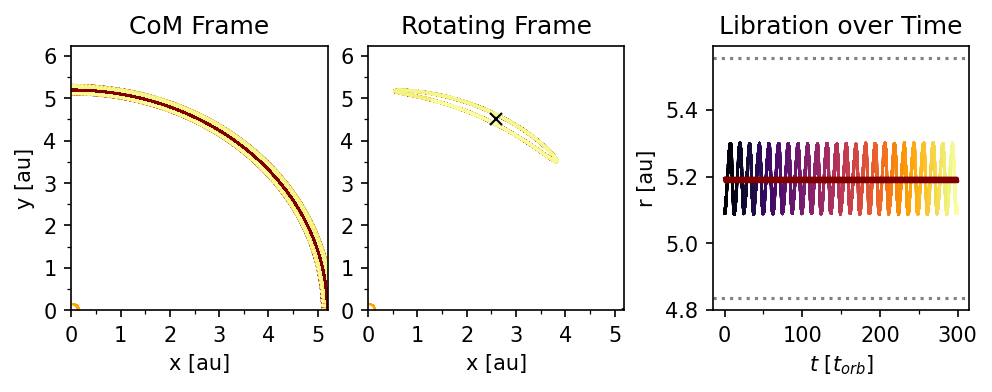

In [9]:
# A simulation for a tadpole orbit for 300 orbits

# Define the position of the Lagrange point here
p_Lpt = p_to_cart(5.2,np.pi/3) #dummy value, replace with your own

# Set initial conditions * HERE *
p_s = (0,0)
v_s = (0,0)
m_s = 1

p_j = p_to_cart(5.2, 0) # position
v_j = set_v(p_j) # velocity
m_j = 1/1000 # mass

# Dummy initial conditions, replace with your own!
p_3 = p_to_cart(5.1, np.pi/3)
v_3 = set_v(p_3)
m_3 = SMALL # the third body should be a 'test mass'



# Change parameters above, not here
Sun = {'m':m_s,'p0':p_s,'u0':v_s,'color':'orange','name':'sun'}
Jupiter = {'m':m_j, 'p0':p_j,'u0':v_j,'color':'maroon','name':'jupiter'}
Third = {'m':m_3, 'p0':p_3,'u0':v_3,'color':'violet','name':'third'}

#length of one orbit for Jupiter in code units
t_orb = T*(p_to_cyl(*p_j)[0])**(3./2.)

#setup and run a simulation
sim = ThreeBody(Sun,Jupiter,Third)
tmax = t_orb*300
err = 1e-8
dt_i = 1e-10
sim.integrate(err, dt_i, tmax)
print('Simulation Done!')
time_orb = np.array(sim.time)/t_orb # time in number of Jupiter orbits

f,(a1,a2,a3) = plt.subplots(1,3,constrained_layout=True,dpi=150)
f.set_size_inches(6.5,2.5)

# CoM Frame
a1.set_title("CoM Frame")
a1.plot(Jupiter['x_cm'],Jupiter['y_cm'],lw=1,color=Jupiter['color'])
a1.plot(Sun['x_cm'],Sun['y_cm'],color=Sun['color'],ls=None,marker='o',mfc='white')
a1.scatter(Third['x_cm'],Third['y_cm'],c=time_orb,s=0.1,cmap='inferno') # colors map to orbital times
a1.set_ylabel('y [au]')

# In (Jupiter's) Rotating Frame w.r.t to the CoM
rj,phij = p_to_cyl(Jupiter['x_cm'],Jupiter['y_cm'])
J_frame = p_rotate((Jupiter['x_cm'],Jupiter['y_cm']),-phij)
S_frame = p_rotate((Sun['x_cm'],Sun['y_cm']),-phij)
T_frame = p_rotate((Third['x_cm'],Third['y_cm']),-phij)

a2.set_title('Rotating Frame')
a2.plot(*J_frame,lw=2,color=Jupiter['color'])
a2.plot(*S_frame,color=Sun['color'],ls=None,marker='o',mfc='white')
a2.scatter(*T_frame,c=time_orb,s=0.1,cmap='inferno')

#plot the location of the Lagrange point
a2.plot(*p_Lpt,marker='x',color='black')

for a in (a1,a2):
    #a.axis('equal')
    a.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    a.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
    a.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    a.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
    a.set_xlim(min(np.amin(T_frame[0]),0),max(np.amax(T_frame[0]),p_j[0]))
    a.set_ylim(min(np.amin(T_frame[1]),0),max(np.amax(T_frame[1])*1.2,p_Lpt[1]))
    a.set_xlabel('x [au]')

# Satellite + Jupiter radial location over time
r3, phi3 = p_to_cyl(Third['x_cm'],Third['y_cm'])
a3.plot(time_orb, rj,color=Jupiter['color'])
a3.scatter(time_orb, r3,c=time_orb,s=0.1,cmap='inferno')

# plot the bounds of Jupiter's hill sphere * HERE *
r_Hill = r_H(5.2, m_j) # Calculate r_Hill * HERE *
a3.axhline(rj[0] + r_Hill, color='gray',ls='dotted')
a3.axhline(rj[0] - r_Hill, color='gray',ls='dotted')

a3.set_xlabel(r'$t \ [t_{orb}]$')

a3.set_title('Libration over Time')
a3.xaxis.set_major_locator(mpl.ticker.MultipleLocator(100))
a3.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(50))
a3.set_ylabel('r [au]')

Simulation Done!


Text(0, 0.5, 'r [au]')

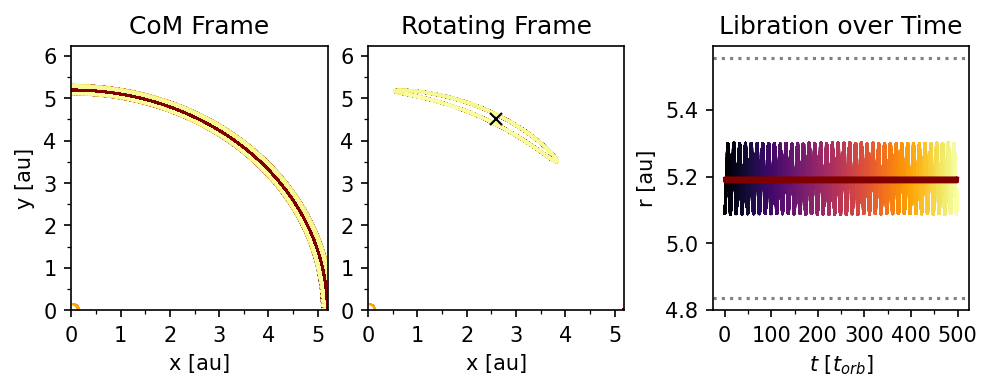

In [10]:
# A simulation for a tadpole orbit for 500 orbits

# Define the position of the Lagrange point here
p_Lpt = p_to_cart(5.2,np.pi/3) #dummy value, replace with your own

# Set initial conditions * HERE *
p_s = (0,0)
v_s = (0,0)
m_s = 1

p_j = p_to_cart(5.2, 0) # position
v_j = set_v(p_j) # velocity
m_j = 1/1000 # mass

# Dummy initial conditions, replace with your own!
p_3 = p_to_cart(5.1, np.pi/3)
v_3 = set_v(p_3)
m_3 = SMALL # the third body should be a 'test mass'



# Change parameters above, not here
Sun = {'m':m_s,'p0':p_s,'u0':v_s,'color':'orange','name':'sun'}
Jupiter = {'m':m_j, 'p0':p_j,'u0':v_j,'color':'maroon','name':'jupiter'}
Third = {'m':m_3, 'p0':p_3,'u0':v_3,'color':'violet','name':'third'}

#length of one orbit for Jupiter in code units
t_orb = T*(p_to_cyl(*p_j)[0])**(3./2.)

#setup and run a simulation
sim = ThreeBody(Sun,Jupiter,Third)
tmax = t_orb*500
err = 1e-8
dt_i = 1e-10
sim.integrate(err, dt_i, tmax)
print('Simulation Done!')
time_orb = np.array(sim.time)/t_orb # time in number of Jupiter orbits

f,(a1,a2,a3) = plt.subplots(1,3,constrained_layout=True,dpi=150)
f.set_size_inches(6.5,2.5)

# CoM Frame
a1.set_title("CoM Frame")
a1.plot(Jupiter['x_cm'],Jupiter['y_cm'],lw=1,color=Jupiter['color'])
a1.plot(Sun['x_cm'],Sun['y_cm'],color=Sun['color'],ls=None,marker='o',mfc='white')
a1.scatter(Third['x_cm'],Third['y_cm'],c=time_orb,s=0.1,cmap='inferno') # colors map to orbital times
a1.set_ylabel('y [au]')

# In (Jupiter's) Rotating Frame w.r.t to the CoM
rj,phij = p_to_cyl(Jupiter['x_cm'],Jupiter['y_cm'])
J_frame = p_rotate((Jupiter['x_cm'],Jupiter['y_cm']),-phij)
S_frame = p_rotate((Sun['x_cm'],Sun['y_cm']),-phij)
T_frame = p_rotate((Third['x_cm'],Third['y_cm']),-phij)

a2.set_title('Rotating Frame')
a2.plot(*J_frame,lw=2,color=Jupiter['color'])
a2.plot(*S_frame,color=Sun['color'],ls=None,marker='o',mfc='white')
a2.scatter(*T_frame,c=time_orb,s=0.1,cmap='inferno')

#plot the location of the Lagrange point
a2.plot(*p_Lpt,marker='x',color='black')

for a in (a1,a2):
    #a.axis('equal')
    a.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    a.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
    a.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    a.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
    a.set_xlim(min(np.amin(T_frame[0]),0),max(np.amax(T_frame[0]),p_j[0]))
    a.set_ylim(min(np.amin(T_frame[1]),0),max(np.amax(T_frame[1])*1.2,p_Lpt[1]))
    a.set_xlabel('x [au]')

# Satellite + Jupiter radial location over time
r3, phi3 = p_to_cyl(Third['x_cm'],Third['y_cm'])
a3.plot(time_orb, rj,color=Jupiter['color'])
a3.scatter(time_orb, r3,c=time_orb,s=0.1,cmap='inferno')

# plot the bounds of Jupiter's hill sphere * HERE *
r_Hill = r_H(5.2, m_j) # Calculate r_Hill * HERE *
a3.axhline(rj[0] + r_Hill, color='gray',ls='dotted')
a3.axhline(rj[0] - r_Hill, color='gray',ls='dotted')

a3.set_xlabel(r'$t \ [t_{orb}]$')

a3.set_title('Libration over Time')
a3.xaxis.set_major_locator(mpl.ticker.MultipleLocator(100))
a3.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(50))
a3.set_ylabel('r [au]')

Simulation Done!


Text(0, 0.5, 'r [au]')

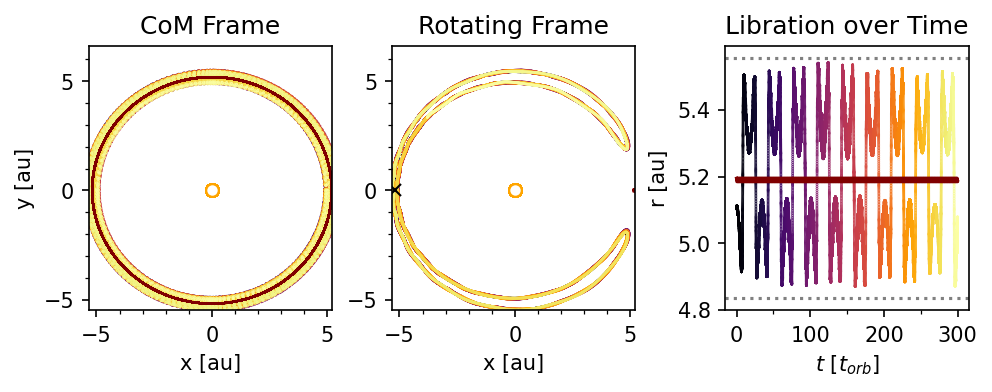

In [11]:
# A simulation for a horseshoe orbit for 300 orbits

# Define the position of the Lagrange point here
p_Lpt = p_to_cart(5.2,np.pi) #dummy value replace with your own

# Set initial conditions * HERE *
p_s = (0,0)# copy from before
v_s = (0,0)
m_s = 1

p_j = p_to_cart(5.2, 0)
v_j = set_v(p_j) # velocity
m_j = 1/1000 

# Dummy initial conditions, replace with your own!
p_3 = p_to_cart(5.1, np.pi)
v_3 = set_v(p_3)
m_3 = SMALL # the third body should be a 'test mass'

Sun = {'m':m_s,'p0':p_s,'u0':v_s,'color':'orange','name':'sun'}
Jupiter = {'m':m_j, 'p0':p_j,'u0':v_j,'color':'maroon','name':'jupiter'}
Third = {'m':m_3, 'p0':p_3,'u0':v_3,'color':'C0','name':'third'}

#length of one orbit for Jupiter in years
t_orb = 2*np.pi*(5.2**1.5)

#setup and run a simulation
tb = ThreeBody(Sun,Jupiter,Third)
tmax = t_orb*300
err = 1e-6
dt_i = 1e-8
tb.integrate(err, dt_i, tmax)
print('Simulation Done!')
time_orb = np.array(tb.time)/t_orb


f,(a1,a2,a3) = plt.subplots(1,3,constrained_layout=True,dpi=150)
f.set_size_inches(6.5,2.5)

# CoM Frame
a1.set_title("CoM Frame")
a1.plot(Jupiter['x_cm'],Jupiter['y_cm'],lw=1,color=Jupiter['color'])
a1.plot(Sun['x_cm'],Sun['y_cm'],color=Sun['color'],ls=None,marker='o',mfc='white')
a1.scatter(Third['x_cm'],Third['y_cm'],c=time_orb,s=0.1,cmap='inferno') # colors map to orbital times
a1.set_ylabel('y [au]')

# In (Jupiter's) Rotating Frame w.r.t to the CoM
rj,phij = p_to_cyl(Jupiter['x_cm'],Jupiter['y_cm'])
J_frame = p_rotate((Jupiter['x_cm'],Jupiter['y_cm']),-phij)
S_frame = p_rotate((Sun['x_cm'],Sun['y_cm']),-phij)
T_frame = p_rotate((Third['x_cm'],Third['y_cm']),-phij)

a2.set_title('Rotating Frame')
a2.plot(*J_frame,lw=2,color=Jupiter['color'])
a2.plot(*S_frame,color=Sun['color'],ls=None,marker='o',mfc='white')
a2.scatter(*T_frame,c=time_orb,s=0.1,cmap='inferno')

#plot the location of the Lagrange point
a2.plot(*p_Lpt,marker='x',color='black')

for a in (a1,a2):
    #a.axis('equal')
    a.xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
    a.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    a.yaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
    a.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    a.set_xlim(min(np.amin(T_frame[0]),0),max(np.amax(T_frame[0]),p_j[0]))
    a.set_ylim(min(np.amin(T_frame[1]),0),max(np.amax(T_frame[1])*1.2,p_Lpt[1]))
    a.set_xlabel('x [au]')

# Satellite + Jupiter radial location over time
r3, phi3 = p_to_cyl(Third['x_cm'],Third['y_cm'])
a3.plot(time_orb, rj,color=Jupiter['color'])
a3.scatter(time_orb, r3,c=time_orb,s=0.1,cmap='inferno')

# plot the bounds of Jupiter's hill sphere * HERE *
r_Hill = r_H(5.2, m_j) # calculate r_Hill * HERE *
a3.axhline(rj[0] + r_Hill, color='gray',ls='dotted')
a3.axhline(rj[0] - r_Hill, color='gray',ls='dotted')

a3.set_xlabel(r'$t \ [t_{orb}]$')
a3.set_title('Libration over Time')
a3.xaxis.set_major_locator(mpl.ticker.MultipleLocator(100))
a3.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(50))
a3.set_ylabel('r [au]')





Simulation Done!


Text(0, 0.5, 'r [au]')

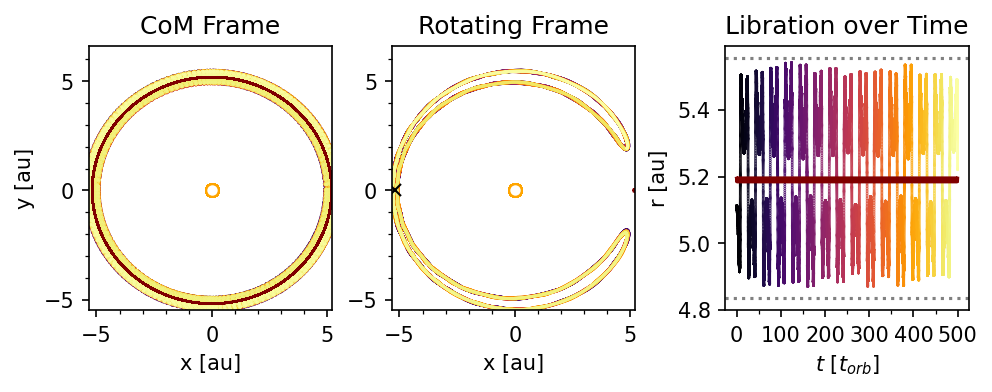

In [12]:
# A simulation for a horsehoe orbit for 500 orbits

# Define the position of the Lagrange point here
p_Lpt = p_to_cart(5.2,np.pi) #dummy value replace with your own

# Set initial conditions * HERE *
p_s = (0,0)# copy from before
v_s = (0,0)
m_s = 1

p_j = p_to_cart(5.2, 0)
v_j = set_v(p_j) # velocity
m_j = 1/1000 

# Dummy initial conditions, replace with your own!
p_3 = p_to_cart(5.1, np.pi)
v_3 = set_v(p_3)
m_3 = SMALL # the third body should be a 'test mass'

Sun = {'m':m_s,'p0':p_s,'u0':v_s,'color':'orange','name':'sun'}
Jupiter = {'m':m_j, 'p0':p_j,'u0':v_j,'color':'maroon','name':'jupiter'}
Third = {'m':m_3, 'p0':p_3,'u0':v_3,'color':'C0','name':'third'}

#length of one orbit for Jupiter in years
t_orb = 2*np.pi*(5.2**1.5)

#setup and run a simulation
tb = ThreeBody(Sun,Jupiter,Third)
tmax = t_orb*500
err = 1e-6
dt_i = 1e-8
tb.integrate(err, dt_i, tmax)
print('Simulation Done!')
time_orb = np.array(tb.time)/t_orb


f,(a1,a2,a3) = plt.subplots(1,3,constrained_layout=True,dpi=150)
f.set_size_inches(6.5,2.5)

# CoM Frame
a1.set_title("CoM Frame")
a1.plot(Jupiter['x_cm'],Jupiter['y_cm'],lw=1,color=Jupiter['color'])
a1.plot(Sun['x_cm'],Sun['y_cm'],color=Sun['color'],ls=None,marker='o',mfc='white')
a1.scatter(Third['x_cm'],Third['y_cm'],c=time_orb,s=0.1,cmap='inferno') # colors map to orbital times
a1.set_ylabel('y [au]')

# In (Jupiter's) Rotating Frame w.r.t to the CoM
rj,phij = p_to_cyl(Jupiter['x_cm'],Jupiter['y_cm'])
J_frame = p_rotate((Jupiter['x_cm'],Jupiter['y_cm']),-phij)
S_frame = p_rotate((Sun['x_cm'],Sun['y_cm']),-phij)
T_frame = p_rotate((Third['x_cm'],Third['y_cm']),-phij)

a2.set_title('Rotating Frame')
a2.plot(*J_frame,lw=2,color=Jupiter['color'])
a2.plot(*S_frame,color=Sun['color'],ls=None,marker='o',mfc='white')
a2.scatter(*T_frame,c=time_orb,s=0.1,cmap='inferno')

#plot the location of the Lagrange point
a2.plot(*p_Lpt,marker='x',color='black')

for a in (a1,a2):
    #a.axis('equal')
    a.xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
    a.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    a.yaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
    a.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    a.set_xlim(min(np.amin(T_frame[0]),0),max(np.amax(T_frame[0]),p_j[0]))
    a.set_ylim(min(np.amin(T_frame[1]),0),max(np.amax(T_frame[1])*1.2,p_Lpt[1]))
    a.set_xlabel('x [au]')

# Satellite + Jupiter radial location over time
r3, phi3 = p_to_cyl(Third['x_cm'],Third['y_cm'])
a3.plot(time_orb, rj,color=Jupiter['color'])
a3.scatter(time_orb, r3,c=time_orb,s=0.1,cmap='inferno')

# plot the bounds of Jupiter's hill sphere * HERE *
r_Hill = r_H(5.2, m_j) # calculate r_Hill * HERE *
a3.axhline(rj[0] + r_Hill, color='gray',ls='dotted')
a3.axhline(rj[0] - r_Hill, color='gray',ls='dotted')

a3.set_xlabel(r'$t \ [t_{orb}]$')
a3.set_title('Libration over Time')
a3.xaxis.set_major_locator(mpl.ticker.MultipleLocator(100))
a3.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(50))
a3.set_ylabel('r [au]')





Simulation Done!


Text(0, 0.5, 'r [au]')

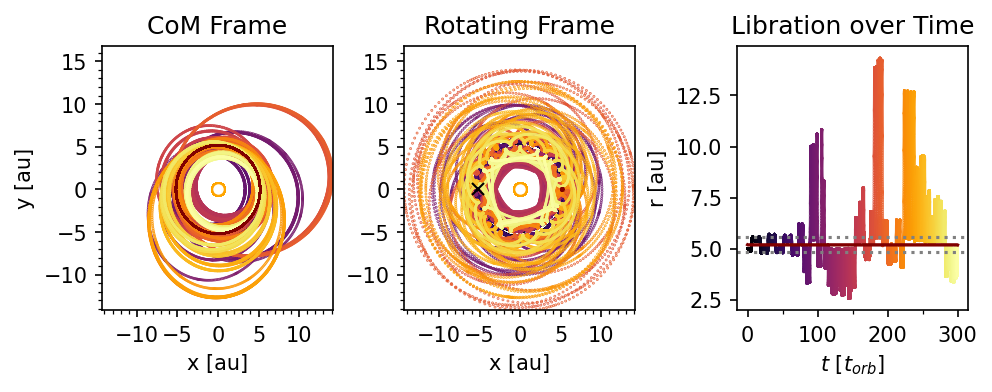

In [13]:
# A simulation for a horseshoe orbit (perturbed 5.0 AU) for 300 orbits

# Define the position of the Lagrange point here
p_Lpt = p_to_cart(5.2,np.pi) #dummy value replace with your own

# Set initial conditions * HERE *
p_s = (0,0)# copy from before
v_s = (0,0)
m_s = 1

p_j = p_to_cart(5.2, 0)
v_j = set_v(p_j) # velocity
m_j = 1/1000 

# Dummy initial conditions, replace with your own!
p_3 = p_to_cart(5.0, np.pi)
v_3 = set_v(p_3)
m_3 = SMALL # the third body should be a 'test mass'

Sun = {'m':m_s,'p0':p_s,'u0':v_s,'color':'orange','name':'sun'}
Jupiter = {'m':m_j, 'p0':p_j,'u0':v_j,'color':'maroon','name':'jupiter'}
Third = {'m':m_3, 'p0':p_3,'u0':v_3,'color':'C0','name':'third'}

#length of one orbit for Jupiter in years
t_orb = 2*np.pi*(5.2**1.5)

#setup and run a simulation
tb = ThreeBody(Sun,Jupiter,Third)
tmax = t_orb*300
err = 1e-6
dt_i = 1e-8
tb.integrate(err, dt_i, tmax)
print('Simulation Done!')
time_orb = np.array(tb.time)/t_orb


f,(a1,a2,a3) = plt.subplots(1,3,constrained_layout=True,dpi=150)
f.set_size_inches(6.5,2.5)

# CoM Frame
a1.set_title("CoM Frame")
a1.plot(Jupiter['x_cm'],Jupiter['y_cm'],lw=1,color=Jupiter['color'])
a1.plot(Sun['x_cm'],Sun['y_cm'],color=Sun['color'],ls=None,marker='o',mfc='white')
a1.scatter(Third['x_cm'],Third['y_cm'],c=time_orb,s=0.1,cmap='inferno') # colors map to orbital times
a1.set_ylabel('y [au]')

# In (Jupiter's) Rotating Frame w.r.t to the CoM
rj,phij = p_to_cyl(Jupiter['x_cm'],Jupiter['y_cm'])
J_frame = p_rotate((Jupiter['x_cm'],Jupiter['y_cm']),-phij)
S_frame = p_rotate((Sun['x_cm'],Sun['y_cm']),-phij)
T_frame = p_rotate((Third['x_cm'],Third['y_cm']),-phij)

a2.set_title('Rotating Frame')
a2.plot(*J_frame,lw=2,color=Jupiter['color'])
a2.plot(*S_frame,color=Sun['color'],ls=None,marker='o',mfc='white')
a2.scatter(*T_frame,c=time_orb,s=0.1,cmap='inferno')

#plot the location of the Lagrange point
a2.plot(*p_Lpt,marker='x',color='black')

for a in (a1,a2):
    #a.axis('equal')
    a.xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
    a.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    a.yaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
    a.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    a.set_xlim(min(np.amin(T_frame[0]),0),max(np.amax(T_frame[0]),p_j[0]))
    a.set_ylim(min(np.amin(T_frame[1]),0),max(np.amax(T_frame[1])*1.2,p_Lpt[1]))
    a.set_xlabel('x [au]')

# Satellite + Jupiter radial location over time
r3, phi3 = p_to_cyl(Third['x_cm'],Third['y_cm'])
a3.plot(time_orb, rj,color=Jupiter['color'])
a3.scatter(time_orb, r3,c=time_orb,s=0.1,cmap='inferno')

# plot the bounds of Jupiter's hill sphere * HERE *
r_Hill = r_H(5.2, m_j) # calculate r_Hill * HERE *
a3.axhline(rj[0] + r_Hill, color='gray',ls='dotted')
a3.axhline(rj[0] - r_Hill, color='gray',ls='dotted')

a3.set_xlabel(r'$t \ [t_{orb}]$')
a3.set_title('Libration over Time')
a3.xaxis.set_major_locator(mpl.ticker.MultipleLocator(100))
a3.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(50))
a3.set_ylabel('r [au]')





Simulation Done!


Text(0, 0.5, 'r [au]')

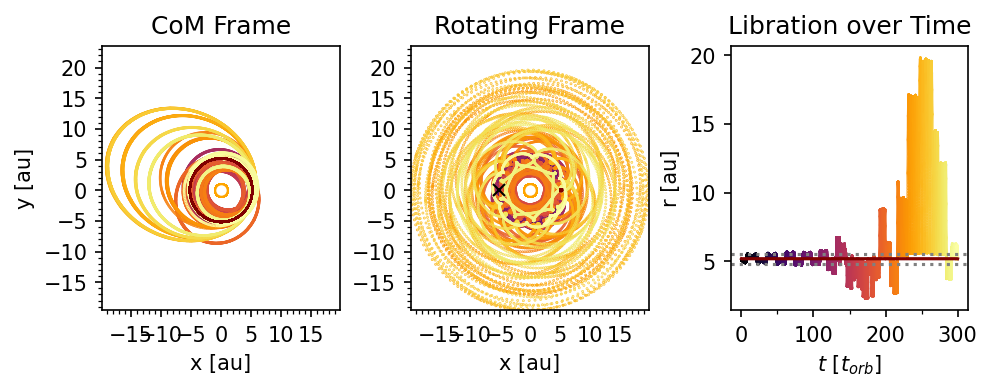

In [14]:
# A simulation for a horseshoe orbit (perturbed 5.05 AU) for 300 orbits

# Define the position of the Lagrange point here
p_Lpt = p_to_cart(5.2,np.pi) #dummy value replace with your own

# Set initial conditions * HERE *
p_s = (0,0)# copy from before
v_s = (0,0)
m_s = 1

p_j = p_to_cart(5.2, 0)
v_j = set_v(p_j) # velocity
m_j = 1/1000 

# Dummy initial conditions, replace with your own!
p_3 = p_to_cart(5.05, np.pi)
v_3 = set_v(p_3)
m_3 = SMALL # the third body should be a 'test mass'

Sun = {'m':m_s,'p0':p_s,'u0':v_s,'color':'orange','name':'sun'}
Jupiter = {'m':m_j, 'p0':p_j,'u0':v_j,'color':'maroon','name':'jupiter'}
Third = {'m':m_3, 'p0':p_3,'u0':v_3,'color':'C0','name':'third'}

#length of one orbit for Jupiter in years
t_orb = 2*np.pi*(5.2**1.5)

#setup and run a simulation
tb = ThreeBody(Sun,Jupiter,Third)
tmax = t_orb*300
err = 1e-6
dt_i = 1e-8
tb.integrate(err, dt_i, tmax)
print('Simulation Done!')
time_orb = np.array(tb.time)/t_orb


f,(a1,a2,a3) = plt.subplots(1,3,constrained_layout=True,dpi=150)
f.set_size_inches(6.5,2.5)

# CoM Frame
a1.set_title("CoM Frame")
a1.plot(Jupiter['x_cm'],Jupiter['y_cm'],lw=1,color=Jupiter['color'])
a1.plot(Sun['x_cm'],Sun['y_cm'],color=Sun['color'],ls=None,marker='o',mfc='white')
a1.scatter(Third['x_cm'],Third['y_cm'],c=time_orb,s=0.1,cmap='inferno') # colors map to orbital times
a1.set_ylabel('y [au]')

# In (Jupiter's) Rotating Frame w.r.t to the CoM
rj,phij = p_to_cyl(Jupiter['x_cm'],Jupiter['y_cm'])
J_frame = p_rotate((Jupiter['x_cm'],Jupiter['y_cm']),-phij)
S_frame = p_rotate((Sun['x_cm'],Sun['y_cm']),-phij)
T_frame = p_rotate((Third['x_cm'],Third['y_cm']),-phij)

a2.set_title('Rotating Frame')
a2.plot(*J_frame,lw=2,color=Jupiter['color'])
a2.plot(*S_frame,color=Sun['color'],ls=None,marker='o',mfc='white')
a2.scatter(*T_frame,c=time_orb,s=0.1,cmap='inferno')

#plot the location of the Lagrange point
a2.plot(*p_Lpt,marker='x',color='black')

for a in (a1,a2):
    #a.axis('equal')
    a.xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
    a.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    a.yaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
    a.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    a.set_xlim(min(np.amin(T_frame[0]),0),max(np.amax(T_frame[0]),p_j[0]))
    a.set_ylim(min(np.amin(T_frame[1]),0),max(np.amax(T_frame[1])*1.2,p_Lpt[1]))
    a.set_xlabel('x [au]')

# Satellite + Jupiter radial location over time
r3, phi3 = p_to_cyl(Third['x_cm'],Third['y_cm'])
a3.plot(time_orb, rj,color=Jupiter['color'])
a3.scatter(time_orb, r3,c=time_orb,s=0.1,cmap='inferno')

# plot the bounds of Jupiter's hill sphere * HERE *
r_Hill = r_H(5.2, m_j) # calculate r_Hill * HERE *
a3.axhline(rj[0] + r_Hill, color='gray',ls='dotted')
a3.axhline(rj[0] - r_Hill, color='gray',ls='dotted')

a3.set_xlabel(r'$t \ [t_{orb}]$')
a3.set_title('Libration over Time')
a3.xaxis.set_major_locator(mpl.ticker.MultipleLocator(100))
a3.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(50))
a3.set_ylabel('r [au]')





Simulation Done!


Text(0, 0.5, 'r [au]')

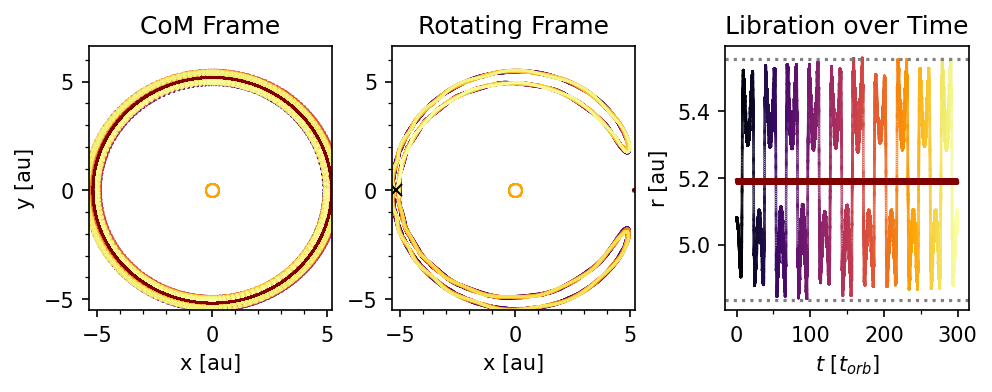

In [15]:
# A simulation for a horseshoe orbit (perturbed 5.07 AU) for 300 orbits

# Define the position of the Lagrange point here
p_Lpt = p_to_cart(5.2,np.pi) #dummy value replace with your own

# Set initial conditions * HERE *
p_s = (0,0)# copy from before
v_s = (0,0)
m_s = 1

p_j = p_to_cart(5.2, 0)
v_j = set_v(p_j) # velocity
m_j = 1/1000 

# Dummy initial conditions, replace with your own!
p_3 = p_to_cart(5.07, np.pi)
v_3 = set_v(p_3)
m_3 = SMALL # the third body should be a 'test mass'

Sun = {'m':m_s,'p0':p_s,'u0':v_s,'color':'orange','name':'sun'}
Jupiter = {'m':m_j, 'p0':p_j,'u0':v_j,'color':'maroon','name':'jupiter'}
Third = {'m':m_3, 'p0':p_3,'u0':v_3,'color':'C0','name':'third'}

#length of one orbit for Jupiter in years
t_orb = 2*np.pi*(5.2**1.5)

#setup and run a simulation
tb = ThreeBody(Sun,Jupiter,Third)
tmax = t_orb*300
err = 1e-6
dt_i = 1e-8
tb.integrate(err, dt_i, tmax)
print('Simulation Done!')
time_orb = np.array(tb.time)/t_orb


f,(a1,a2,a3) = plt.subplots(1,3,constrained_layout=True,dpi=150)
f.set_size_inches(6.5,2.5)

# CoM Frame
a1.set_title("CoM Frame")
a1.plot(Jupiter['x_cm'],Jupiter['y_cm'],lw=1,color=Jupiter['color'])
a1.plot(Sun['x_cm'],Sun['y_cm'],color=Sun['color'],ls=None,marker='o',mfc='white')
a1.scatter(Third['x_cm'],Third['y_cm'],c=time_orb,s=0.1,cmap='inferno') # colors map to orbital times
a1.set_ylabel('y [au]')

# In (Jupiter's) Rotating Frame w.r.t to the CoM
rj,phij = p_to_cyl(Jupiter['x_cm'],Jupiter['y_cm'])
J_frame = p_rotate((Jupiter['x_cm'],Jupiter['y_cm']),-phij)
S_frame = p_rotate((Sun['x_cm'],Sun['y_cm']),-phij)
T_frame = p_rotate((Third['x_cm'],Third['y_cm']),-phij)

a2.set_title('Rotating Frame')
a2.plot(*J_frame,lw=2,color=Jupiter['color'])
a2.plot(*S_frame,color=Sun['color'],ls=None,marker='o',mfc='white')
a2.scatter(*T_frame,c=time_orb,s=0.1,cmap='inferno')

#plot the location of the Lagrange point
a2.plot(*p_Lpt,marker='x',color='black')

for a in (a1,a2):
    #a.axis('equal')
    a.xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
    a.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    a.yaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
    a.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    a.set_xlim(min(np.amin(T_frame[0]),0),max(np.amax(T_frame[0]),p_j[0]))
    a.set_ylim(min(np.amin(T_frame[1]),0),max(np.amax(T_frame[1])*1.2,p_Lpt[1]))
    a.set_xlabel('x [au]')

# Satellite + Jupiter radial location over time
r3, phi3 = p_to_cyl(Third['x_cm'],Third['y_cm'])
a3.plot(time_orb, rj,color=Jupiter['color'])
a3.scatter(time_orb, r3,c=time_orb,s=0.1,cmap='inferno')

# plot the bounds of Jupiter's hill sphere * HERE *
r_Hill = r_H(5.2, m_j) # calculate r_Hill * HERE *
a3.axhline(rj[0] + r_Hill, color='gray',ls='dotted')
a3.axhline(rj[0] - r_Hill, color='gray',ls='dotted')

a3.set_xlabel(r'$t \ [t_{orb}]$')
a3.set_title('Libration over Time')
a3.xaxis.set_major_locator(mpl.ticker.MultipleLocator(100))
a3.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(50))
a3.set_ylabel('r [au]')





Simulation Done!


Text(0, 0.5, 'r [au]')

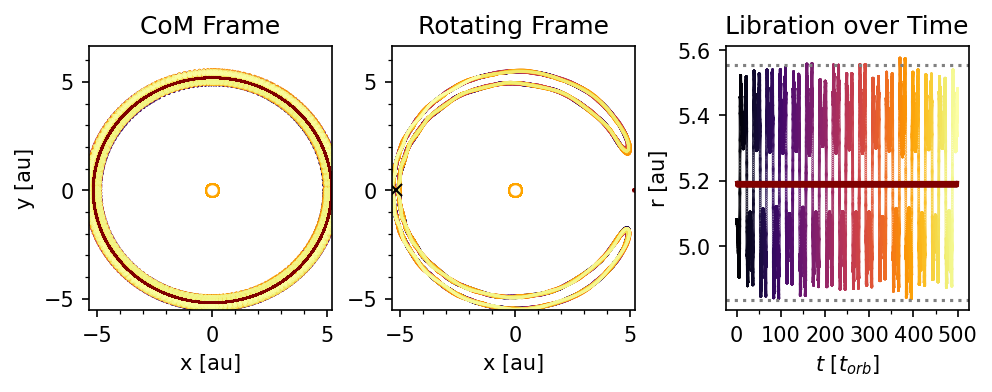

In [16]:
# A simulation for a horseshoe orbit (perturbed 5.07 AU) for 500 orbits

# Define the position of the Lagrange point here
p_Lpt = p_to_cart(5.2,np.pi) #dummy value replace with your own

# Set initial conditions * HERE *
p_s = (0,0)# copy from before
v_s = (0,0)
m_s = 1

p_j = p_to_cart(5.2, 0)
v_j = set_v(p_j) # velocity
m_j = 1/1000 

# Dummy initial conditions, replace with your own!
p_3 = p_to_cart(5.07, np.pi)
v_3 = set_v(p_3)
m_3 = SMALL # the third body should be a 'test mass'

Sun = {'m':m_s,'p0':p_s,'u0':v_s,'color':'orange','name':'sun'}
Jupiter = {'m':m_j, 'p0':p_j,'u0':v_j,'color':'maroon','name':'jupiter'}
Third = {'m':m_3, 'p0':p_3,'u0':v_3,'color':'C0','name':'third'}

#length of one orbit for Jupiter in years
t_orb = 2*np.pi*(5.2**1.5)

#setup and run a simulation
tb = ThreeBody(Sun,Jupiter,Third)
tmax = t_orb*500
err = 1e-6
dt_i = 1e-8
tb.integrate(err, dt_i, tmax)
print('Simulation Done!')
time_orb = np.array(tb.time)/t_orb


f,(a1,a2,a3) = plt.subplots(1,3,constrained_layout=True,dpi=150)
f.set_size_inches(6.5,2.5)

# CoM Frame
a1.set_title("CoM Frame")
a1.plot(Jupiter['x_cm'],Jupiter['y_cm'],lw=1,color=Jupiter['color'])
a1.plot(Sun['x_cm'],Sun['y_cm'],color=Sun['color'],ls=None,marker='o',mfc='white')
a1.scatter(Third['x_cm'],Third['y_cm'],c=time_orb,s=0.1,cmap='inferno') # colors map to orbital times
a1.set_ylabel('y [au]')

# In (Jupiter's) Rotating Frame w.r.t to the CoM
rj,phij = p_to_cyl(Jupiter['x_cm'],Jupiter['y_cm'])
J_frame = p_rotate((Jupiter['x_cm'],Jupiter['y_cm']),-phij)
S_frame = p_rotate((Sun['x_cm'],Sun['y_cm']),-phij)
T_frame = p_rotate((Third['x_cm'],Third['y_cm']),-phij)

a2.set_title('Rotating Frame')
a2.plot(*J_frame,lw=2,color=Jupiter['color'])
a2.plot(*S_frame,color=Sun['color'],ls=None,marker='o',mfc='white')
a2.scatter(*T_frame,c=time_orb,s=0.1,cmap='inferno')

#plot the location of the Lagrange point
a2.plot(*p_Lpt,marker='x',color='black')

for a in (a1,a2):
    #a.axis('equal')
    a.xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
    a.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    a.yaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
    a.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    a.set_xlim(min(np.amin(T_frame[0]),0),max(np.amax(T_frame[0]),p_j[0]))
    a.set_ylim(min(np.amin(T_frame[1]),0),max(np.amax(T_frame[1])*1.2,p_Lpt[1]))
    a.set_xlabel('x [au]')

# Satellite + Jupiter radial location over time
r3, phi3 = p_to_cyl(Third['x_cm'],Third['y_cm'])
a3.plot(time_orb, rj,color=Jupiter['color'])
a3.scatter(time_orb, r3,c=time_orb,s=0.1,cmap='inferno')

# plot the bounds of Jupiter's hill sphere * HERE *
r_Hill = r_H(5.2, m_j) # calculate r_Hill * HERE *
a3.axhline(rj[0] + r_Hill, color='gray',ls='dotted')
a3.axhline(rj[0] - r_Hill, color='gray',ls='dotted')

a3.set_xlabel(r'$t \ [t_{orb}]$')
a3.set_title('Libration over Time')
a3.xaxis.set_major_locator(mpl.ticker.MultipleLocator(100))
a3.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(50))
a3.set_ylabel('r [au]')





Simulation Done!


Text(0, 0.5, 'r [au]')

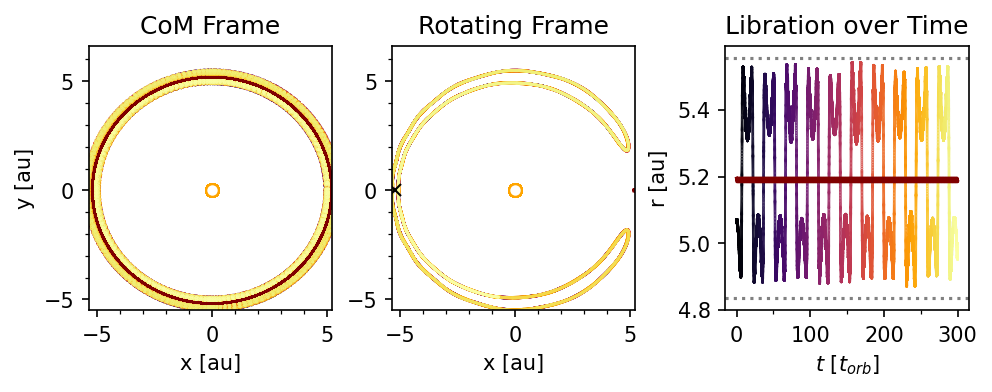

In [17]:
# A simulation for a horseshoe orbit (perturbed 5.06 AU) for 300 orbits

# Define the position of the Lagrange point here
p_Lpt = p_to_cart(5.2,np.pi) #dummy value replace with your own

# Set initial conditions * HERE *
p_s = (0,0)# copy from before
v_s = (0,0)
m_s = 1

p_j = p_to_cart(5.2, 0)
v_j = set_v(p_j) # velocity
m_j = 1/1000 

# Dummy initial conditions, replace with your own!
p_3 = p_to_cart(5.06, np.pi)
v_3 = set_v(p_3)
m_3 = SMALL # the third body should be a 'test mass'

Sun = {'m':m_s,'p0':p_s,'u0':v_s,'color':'orange','name':'sun'}
Jupiter = {'m':m_j, 'p0':p_j,'u0':v_j,'color':'maroon','name':'jupiter'}
Third = {'m':m_3, 'p0':p_3,'u0':v_3,'color':'C0','name':'third'}

#length of one orbit for Jupiter in years
t_orb = 2*np.pi*(5.2**1.5)

#setup and run a simulation
tb = ThreeBody(Sun,Jupiter,Third)
tmax = t_orb*300
err = 1e-6
dt_i = 1e-8
tb.integrate(err, dt_i, tmax)
print('Simulation Done!')
time_orb = np.array(tb.time)/t_orb


f,(a1,a2,a3) = plt.subplots(1,3,constrained_layout=True,dpi=150)
f.set_size_inches(6.5,2.5)

# CoM Frame
a1.set_title("CoM Frame")
a1.plot(Jupiter['x_cm'],Jupiter['y_cm'],lw=1,color=Jupiter['color'])
a1.plot(Sun['x_cm'],Sun['y_cm'],color=Sun['color'],ls=None,marker='o',mfc='white')
a1.scatter(Third['x_cm'],Third['y_cm'],c=time_orb,s=0.1,cmap='inferno') # colors map to orbital times
a1.set_ylabel('y [au]')

# In (Jupiter's) Rotating Frame w.r.t to the CoM
rj,phij = p_to_cyl(Jupiter['x_cm'],Jupiter['y_cm'])
J_frame = p_rotate((Jupiter['x_cm'],Jupiter['y_cm']),-phij)
S_frame = p_rotate((Sun['x_cm'],Sun['y_cm']),-phij)
T_frame = p_rotate((Third['x_cm'],Third['y_cm']),-phij)

a2.set_title('Rotating Frame')
a2.plot(*J_frame,lw=2,color=Jupiter['color'])
a2.plot(*S_frame,color=Sun['color'],ls=None,marker='o',mfc='white')
a2.scatter(*T_frame,c=time_orb,s=0.1,cmap='inferno')

#plot the location of the Lagrange point
a2.plot(*p_Lpt,marker='x',color='black')

for a in (a1,a2):
    #a.axis('equal')
    a.xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
    a.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    a.yaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
    a.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    a.set_xlim(min(np.amin(T_frame[0]),0),max(np.amax(T_frame[0]),p_j[0]))
    a.set_ylim(min(np.amin(T_frame[1]),0),max(np.amax(T_frame[1])*1.2,p_Lpt[1]))
    a.set_xlabel('x [au]')

# Satellite + Jupiter radial location over time
r3, phi3 = p_to_cyl(Third['x_cm'],Third['y_cm'])
a3.plot(time_orb, rj,color=Jupiter['color'])
a3.scatter(time_orb, r3,c=time_orb,s=0.1,cmap='inferno')

# plot the bounds of Jupiter's hill sphere * HERE *
r_Hill = r_H(5.2, m_j) # calculate r_Hill * HERE *
a3.axhline(rj[0] + r_Hill, color='gray',ls='dotted')
a3.axhline(rj[0] - r_Hill, color='gray',ls='dotted')

a3.set_xlabel(r'$t \ [t_{orb}]$')
a3.set_title('Libration over Time')
a3.xaxis.set_major_locator(mpl.ticker.MultipleLocator(100))
a3.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(50))
a3.set_ylabel('r [au]')





Simulation Done!


Text(0, 0.5, 'r [au]')

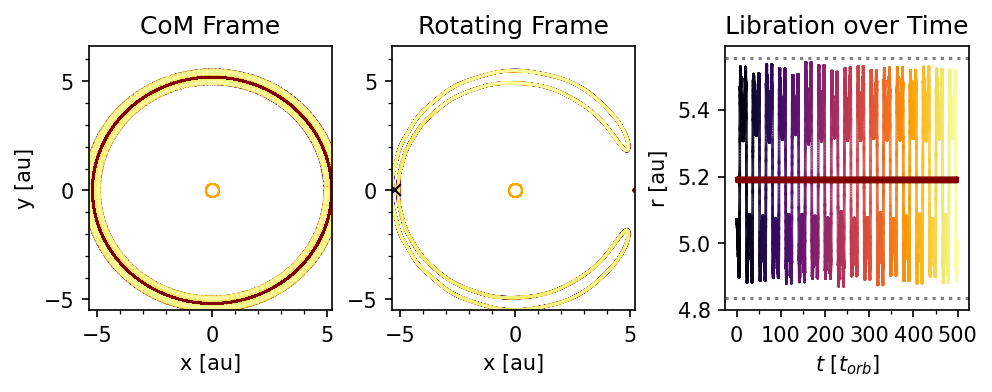

In [18]:
# A simulation for a horseshoe orbit (perturbed 5.06 AU) for 500 orbits

# Define the position of the Lagrange point here
p_Lpt = p_to_cart(5.2,np.pi) #dummy value replace with your own

# Set initial conditions * HERE *
p_s = (0,0)# copy from before
v_s = (0,0)
m_s = 1

p_j = p_to_cart(5.2, 0)
v_j = set_v(p_j) # velocity
m_j = 1/1000 

# Dummy initial conditions, replace with your own!
p_3 = p_to_cart(5.06, np.pi)
v_3 = set_v(p_3)
m_3 = SMALL # the third body should be a 'test mass'

Sun = {'m':m_s,'p0':p_s,'u0':v_s,'color':'orange','name':'sun'}
Jupiter = {'m':m_j, 'p0':p_j,'u0':v_j,'color':'maroon','name':'jupiter'}
Third = {'m':m_3, 'p0':p_3,'u0':v_3,'color':'C0','name':'third'}

#length of one orbit for Jupiter in years
t_orb = 2*np.pi*(5.2**1.5)

#setup and run a simulation
tb = ThreeBody(Sun,Jupiter,Third)
tmax = t_orb*500
err = 1e-6
dt_i = 1e-8
tb.integrate(err, dt_i, tmax)
print('Simulation Done!')
time_orb = np.array(tb.time)/t_orb


f,(a1,a2,a3) = plt.subplots(1,3,constrained_layout=True,dpi=150)
f.set_size_inches(6.5,2.5)

# CoM Frame
a1.set_title("CoM Frame")
a1.plot(Jupiter['x_cm'],Jupiter['y_cm'],lw=1,color=Jupiter['color'])
a1.plot(Sun['x_cm'],Sun['y_cm'],color=Sun['color'],ls=None,marker='o',mfc='white')
a1.scatter(Third['x_cm'],Third['y_cm'],c=time_orb,s=0.1,cmap='inferno') # colors map to orbital times
a1.set_ylabel('y [au]')

# In (Jupiter's) Rotating Frame w.r.t to the CoM
rj,phij = p_to_cyl(Jupiter['x_cm'],Jupiter['y_cm'])
J_frame = p_rotate((Jupiter['x_cm'],Jupiter['y_cm']),-phij)
S_frame = p_rotate((Sun['x_cm'],Sun['y_cm']),-phij)
T_frame = p_rotate((Third['x_cm'],Third['y_cm']),-phij)

a2.set_title('Rotating Frame')
a2.plot(*J_frame,lw=2,color=Jupiter['color'])
a2.plot(*S_frame,color=Sun['color'],ls=None,marker='o',mfc='white')
a2.scatter(*T_frame,c=time_orb,s=0.1,cmap='inferno')

#plot the location of the Lagrange point
a2.plot(*p_Lpt,marker='x',color='black')

for a in (a1,a2):
    #a.axis('equal')
    a.xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
    a.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    a.yaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
    a.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    a.set_xlim(min(np.amin(T_frame[0]),0),max(np.amax(T_frame[0]),p_j[0]))
    a.set_ylim(min(np.amin(T_frame[1]),0),max(np.amax(T_frame[1])*1.2,p_Lpt[1]))
    a.set_xlabel('x [au]')

# Satellite + Jupiter radial location over time
r3, phi3 = p_to_cyl(Third['x_cm'],Third['y_cm'])
a3.plot(time_orb, rj,color=Jupiter['color'])
a3.scatter(time_orb, r3,c=time_orb,s=0.1,cmap='inferno')

# plot the bounds of Jupiter's hill sphere * HERE *
r_Hill = r_H(5.2, m_j) # calculate r_Hill * HERE *
a3.axhline(rj[0] + r_Hill, color='gray',ls='dotted')
a3.axhline(rj[0] - r_Hill, color='gray',ls='dotted')

a3.set_xlabel(r'$t \ [t_{orb}]$')
a3.set_title('Libration over Time')
a3.xaxis.set_major_locator(mpl.ticker.MultipleLocator(100))
a3.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(50))
a3.set_ylabel('r [au]')





Simulation Done!


Text(0, 0.5, 'r [au]')

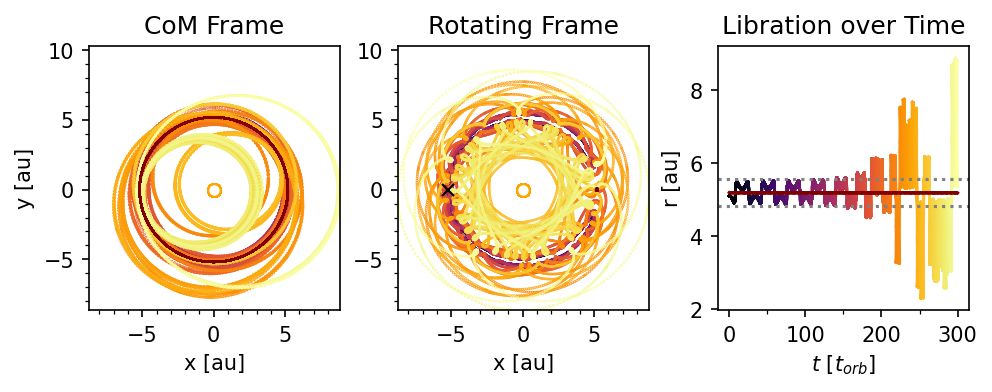

In [19]:
# A simulation for a horseshoe orbit (perturbed 0.05 radians) for 300 orbits

# Define the position of the Lagrange point here
p_Lpt = p_to_cart(5.2,np.pi) #dummy value replace with your own

# Set initial conditions * HERE *
p_s = (0,0)# copy from before
v_s = (0,0)
m_s = 1

p_j = p_to_cart(5.2, 0)
v_j = set_v(p_j) # velocity
m_j = 1/1000 

# Dummy initial conditions, replace with your own!
p_3 = p_to_cart(5.1, np.pi + 0.05)
v_3 = set_v(p_3)
m_3 = SMALL # the third body should be a 'test mass'

Sun = {'m':m_s,'p0':p_s,'u0':v_s,'color':'orange','name':'sun'}
Jupiter = {'m':m_j, 'p0':p_j,'u0':v_j,'color':'maroon','name':'jupiter'}
Third = {'m':m_3, 'p0':p_3,'u0':v_3,'color':'C0','name':'third'}

#length of one orbit for Jupiter in years
t_orb = 2*np.pi*(5.2**1.5)

#setup and run a simulation
tb = ThreeBody(Sun,Jupiter,Third)
tmax = t_orb*300
err = 1e-6
dt_i = 1e-8
tb.integrate(err, dt_i, tmax)
print('Simulation Done!')
time_orb = np.array(tb.time)/t_orb


f,(a1,a2,a3) = plt.subplots(1,3,constrained_layout=True,dpi=150)
f.set_size_inches(6.5,2.5)

# CoM Frame
a1.set_title("CoM Frame")
a1.plot(Jupiter['x_cm'],Jupiter['y_cm'],lw=1,color=Jupiter['color'])
a1.plot(Sun['x_cm'],Sun['y_cm'],color=Sun['color'],ls=None,marker='o',mfc='white')
a1.scatter(Third['x_cm'],Third['y_cm'],c=time_orb,s=0.1,cmap='inferno') # colors map to orbital times
a1.set_ylabel('y [au]')

# In (Jupiter's) Rotating Frame w.r.t to the CoM
rj,phij = p_to_cyl(Jupiter['x_cm'],Jupiter['y_cm'])
J_frame = p_rotate((Jupiter['x_cm'],Jupiter['y_cm']),-phij)
S_frame = p_rotate((Sun['x_cm'],Sun['y_cm']),-phij)
T_frame = p_rotate((Third['x_cm'],Third['y_cm']),-phij)

a2.set_title('Rotating Frame')
a2.plot(*J_frame,lw=2,color=Jupiter['color'])
a2.plot(*S_frame,color=Sun['color'],ls=None,marker='o',mfc='white')
a2.scatter(*T_frame,c=time_orb,s=0.1,cmap='inferno')

#plot the location of the Lagrange point
a2.plot(*p_Lpt,marker='x',color='black')

for a in (a1,a2):
    #a.axis('equal')
    a.xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
    a.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    a.yaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
    a.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    a.set_xlim(min(np.amin(T_frame[0]),0),max(np.amax(T_frame[0]),p_j[0]))
    a.set_ylim(min(np.amin(T_frame[1]),0),max(np.amax(T_frame[1])*1.2,p_Lpt[1]))
    a.set_xlabel('x [au]')

# Satellite + Jupiter radial location over time
r3, phi3 = p_to_cyl(Third['x_cm'],Third['y_cm'])
a3.plot(time_orb, rj,color=Jupiter['color'])
a3.scatter(time_orb, r3,c=time_orb,s=0.1,cmap='inferno')

# plot the bounds of Jupiter's hill sphere * HERE *
r_Hill = r_H(5.2, m_j) # calculate r_Hill * HERE *
a3.axhline(rj[0] + r_Hill, color='gray',ls='dotted')
a3.axhline(rj[0] - r_Hill, color='gray',ls='dotted')

a3.set_xlabel(r'$t \ [t_{orb}]$')
a3.set_title('Libration over Time')
a3.xaxis.set_major_locator(mpl.ticker.MultipleLocator(100))
a3.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(50))
a3.set_ylabel('r [au]')





Simulation Done!


Text(0, 0.5, 'r [au]')

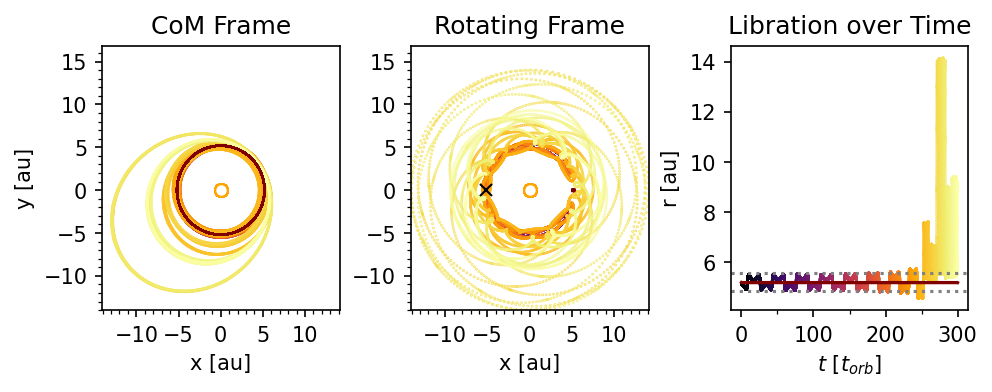

In [20]:
# A simulation for a horseshoe orbit (perturbed 0.025 radians) for 300 orbits

# Define the position of the Lagrange point here
p_Lpt = p_to_cart(5.2,np.pi) #dummy value replace with your own

# Set initial conditions * HERE *
p_s = (0,0)# copy from before
v_s = (0,0)
m_s = 1

p_j = p_to_cart(5.2, 0)
v_j = set_v(p_j) # velocity
m_j = 1/1000 

# Dummy initial conditions, replace with your own!
p_3 = p_to_cart(5.1, np.pi + 0.025)
v_3 = set_v(p_3)
m_3 = SMALL # the third body should be a 'test mass'

Sun = {'m':m_s,'p0':p_s,'u0':v_s,'color':'orange','name':'sun'}
Jupiter = {'m':m_j, 'p0':p_j,'u0':v_j,'color':'maroon','name':'jupiter'}
Third = {'m':m_3, 'p0':p_3,'u0':v_3,'color':'C0','name':'third'}

#length of one orbit for Jupiter in years
t_orb = 2*np.pi*(5.2**1.5)

#setup and run a simulation
tb = ThreeBody(Sun,Jupiter,Third)
tmax = t_orb*300
err = 1e-6
dt_i = 1e-8
tb.integrate(err, dt_i, tmax)
print('Simulation Done!')
time_orb = np.array(tb.time)/t_orb


f,(a1,a2,a3) = plt.subplots(1,3,constrained_layout=True,dpi=150)
f.set_size_inches(6.5,2.5)

# CoM Frame
a1.set_title("CoM Frame")
a1.plot(Jupiter['x_cm'],Jupiter['y_cm'],lw=1,color=Jupiter['color'])
a1.plot(Sun['x_cm'],Sun['y_cm'],color=Sun['color'],ls=None,marker='o',mfc='white')
a1.scatter(Third['x_cm'],Third['y_cm'],c=time_orb,s=0.1,cmap='inferno') # colors map to orbital times
a1.set_ylabel('y [au]')

# In (Jupiter's) Rotating Frame w.r.t to the CoM
rj,phij = p_to_cyl(Jupiter['x_cm'],Jupiter['y_cm'])
J_frame = p_rotate((Jupiter['x_cm'],Jupiter['y_cm']),-phij)
S_frame = p_rotate((Sun['x_cm'],Sun['y_cm']),-phij)
T_frame = p_rotate((Third['x_cm'],Third['y_cm']),-phij)

a2.set_title('Rotating Frame')
a2.plot(*J_frame,lw=2,color=Jupiter['color'])
a2.plot(*S_frame,color=Sun['color'],ls=None,marker='o',mfc='white')
a2.scatter(*T_frame,c=time_orb,s=0.1,cmap='inferno')

#plot the location of the Lagrange point
a2.plot(*p_Lpt,marker='x',color='black')

for a in (a1,a2):
    #a.axis('equal')
    a.xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
    a.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    a.yaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
    a.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    a.set_xlim(min(np.amin(T_frame[0]),0),max(np.amax(T_frame[0]),p_j[0]))
    a.set_ylim(min(np.amin(T_frame[1]),0),max(np.amax(T_frame[1])*1.2,p_Lpt[1]))
    a.set_xlabel('x [au]')

# Satellite + Jupiter radial location over time
r3, phi3 = p_to_cyl(Third['x_cm'],Third['y_cm'])
a3.plot(time_orb, rj,color=Jupiter['color'])
a3.scatter(time_orb, r3,c=time_orb,s=0.1,cmap='inferno')

# plot the bounds of Jupiter's hill sphere * HERE *
r_Hill = r_H(5.2, m_j) # calculate r_Hill * HERE *
a3.axhline(rj[0] + r_Hill, color='gray',ls='dotted')
a3.axhline(rj[0] - r_Hill, color='gray',ls='dotted')

a3.set_xlabel(r'$t \ [t_{orb}]$')
a3.set_title('Libration over Time')
a3.xaxis.set_major_locator(mpl.ticker.MultipleLocator(100))
a3.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(50))
a3.set_ylabel('r [au]')





Simulation Done!


Text(0, 0.5, 'r [au]')

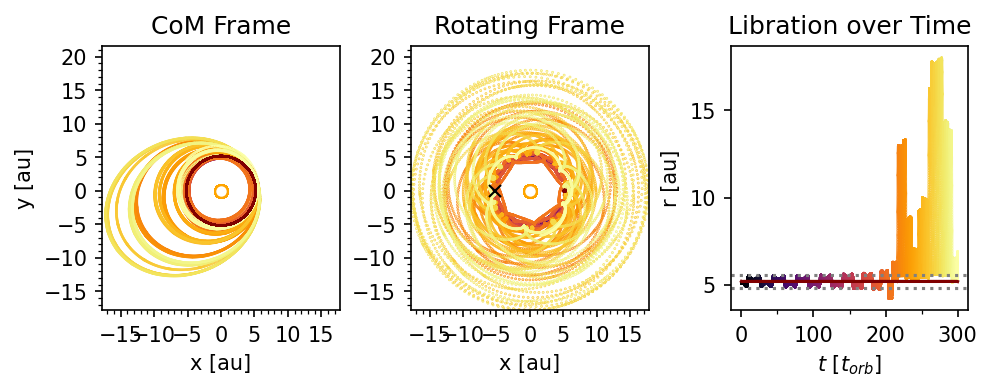

In [21]:
# A simulation for a horseshoe orbit (perturbed 0.01 radians) for 300 orbits

# Define the position of the Lagrange point here
p_Lpt = p_to_cart(5.2,np.pi) #dummy value replace with your own

# Set initial conditions * HERE *
p_s = (0,0)# copy from before
v_s = (0,0)
m_s = 1

p_j = p_to_cart(5.2, 0)
v_j = set_v(p_j) # velocity
m_j = 1/1000 

# Dummy initial conditions, replace with your own!
p_3 = p_to_cart(5.1, np.pi + 0.01)
v_3 = set_v(p_3)
m_3 = SMALL # the third body should be a 'test mass'

Sun = {'m':m_s,'p0':p_s,'u0':v_s,'color':'orange','name':'sun'}
Jupiter = {'m':m_j, 'p0':p_j,'u0':v_j,'color':'maroon','name':'jupiter'}
Third = {'m':m_3, 'p0':p_3,'u0':v_3,'color':'C0','name':'third'}

#length of one orbit for Jupiter in years
t_orb = 2*np.pi*(5.2**1.5)

#setup and run a simulation
tb = ThreeBody(Sun,Jupiter,Third)
tmax = t_orb*300
err = 1e-6
dt_i = 1e-8
tb.integrate(err, dt_i, tmax)
print('Simulation Done!')
time_orb = np.array(tb.time)/t_orb


f,(a1,a2,a3) = plt.subplots(1,3,constrained_layout=True,dpi=150)
f.set_size_inches(6.5,2.5)

# CoM Frame
a1.set_title("CoM Frame")
a1.plot(Jupiter['x_cm'],Jupiter['y_cm'],lw=1,color=Jupiter['color'])
a1.plot(Sun['x_cm'],Sun['y_cm'],color=Sun['color'],ls=None,marker='o',mfc='white')
a1.scatter(Third['x_cm'],Third['y_cm'],c=time_orb,s=0.1,cmap='inferno') # colors map to orbital times
a1.set_ylabel('y [au]')

# In (Jupiter's) Rotating Frame w.r.t to the CoM
rj,phij = p_to_cyl(Jupiter['x_cm'],Jupiter['y_cm'])
J_frame = p_rotate((Jupiter['x_cm'],Jupiter['y_cm']),-phij)
S_frame = p_rotate((Sun['x_cm'],Sun['y_cm']),-phij)
T_frame = p_rotate((Third['x_cm'],Third['y_cm']),-phij)

a2.set_title('Rotating Frame')
a2.plot(*J_frame,lw=2,color=Jupiter['color'])
a2.plot(*S_frame,color=Sun['color'],ls=None,marker='o',mfc='white')
a2.scatter(*T_frame,c=time_orb,s=0.1,cmap='inferno')

#plot the location of the Lagrange point
a2.plot(*p_Lpt,marker='x',color='black')

for a in (a1,a2):
    #a.axis('equal')
    a.xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
    a.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    a.yaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
    a.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    a.set_xlim(min(np.amin(T_frame[0]),0),max(np.amax(T_frame[0]),p_j[0]))
    a.set_ylim(min(np.amin(T_frame[1]),0),max(np.amax(T_frame[1])*1.2,p_Lpt[1]))
    a.set_xlabel('x [au]')

# Satellite + Jupiter radial location over time
r3, phi3 = p_to_cyl(Third['x_cm'],Third['y_cm'])
a3.plot(time_orb, rj,color=Jupiter['color'])
a3.scatter(time_orb, r3,c=time_orb,s=0.1,cmap='inferno')

# plot the bounds of Jupiter's hill sphere * HERE *
r_Hill = r_H(5.2, m_j) # calculate r_Hill * HERE *
a3.axhline(rj[0] + r_Hill, color='gray',ls='dotted')
a3.axhline(rj[0] - r_Hill, color='gray',ls='dotted')

a3.set_xlabel(r'$t \ [t_{orb}]$')
a3.set_title('Libration over Time')
a3.xaxis.set_major_locator(mpl.ticker.MultipleLocator(100))
a3.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(50))
a3.set_ylabel('r [au]')





### Questions

> Q1. Describe the main results for each of the three simulations in terms of orbital behavior, characteristics, and evolution over time.

Simulations One and Two (simulations for a tadpole orbit for 300 and 500 orbits with inital conditions (5.1, $\pi/3$) in polar coordinate position): The small satellite starts 0.1 AU from L4, and oscillates around the Lagrange point, tracing a small tadpole shape as observed in the Rotating Frame graph. In both the 300 and 500 Jupiter orbits, the tadpole orbit remains in regular libration motion and within Jupiter's Hill Sphere, making it stable over a long period of time. 

Simulations Three and Four (simulations for a horseshoe orbit for 300 and 500 orbits with inital conditions (5.1, $\pi$) in polar coordinate position): The small satellite starts 0.1 AU from L3, and forms a horseshoe orbit encompassing L3, L4, and L5. There is more observed variation in the horseshoe orbit as the Libiration over Time graph is not as consistent as that of a tadpole's orbit. However, with this configuration for both 300 and 500 Jupiter orbits, the third bodies remains within the Hill sphere, making this specific set of parameters stable. 

Simulations Five and Six (simulations for the horseshoe oribit inital conditions pertubed by $dr = -0.1, -0.05 $ for 300 orbits): The small satellite starts 0.1 AU from L3 with perturbations of both 0.1 and 0.05, and initally forms a horseshoe orbit encompassing L3, L4, and L5. However, it deviates more significantly from the horseshoe orbits from the perturbations. Due to these perturbations the radial width of liberation quickly causes the orbiting body to became unstable and spiral away from the Lagrange points and the Sun, Jupiter system. With a 0.1 AU perturbation the satellite exits the Hill Sphere intially around 75 Jupiter orbitals while 0.05 AU the system is generally stable until 125 orbits. Though overtime both perturbations results in a chaotic orbital pattern.

Simulations Seven, Eight, Nine, ans Ten (simulations for the horseshoe oribit inital conditions pertubed by $dr = -0.03, 0,04$ for 300 and 500 orbits): The small satellite starts 0.1 AU from L3 with perturbations of 0.03 and 0.04 AU, and forms a horseshoe orbit encompassing L3, L4, and L5. Unlike the previous perturbations this one remains in the horsehoe pattern of both 300 and 500 orbits. However, the Libiration over Time graph depicts that the radial width of the body is barely within the Hill sphere for 300 orbits and starts to liberate further than Jupiter's Hill radius in the 500 orbits Libration over Time graph. However, both conditions do not show any chatotic behaviour on the chosen timescale. 


Simulations Eleven, Twelve, and Thirteen (simulations for the horseshoe oribit inital conditions pertubed by $d\phi = 0.05, 0.025, 0.01$ for 300 orbits): The small satellite starts 0.1 AU from L3 with perturbations of 0.05, 0.025, and 0.01 radians, and likely forms a horseshoe orbit encompassing L3, L4, and L5 (though unclear from the graphs). For all $d\phi$ perturbations, the orbit quickly becomes unstable for 150, 250, 200 Jupiter orbits respecitvely. In the CoM frame, it can be observed that the satellite begins to move in a more eccentric orbit for small perturbations, while larger like 0.05 the motion is complete chaos. In all Liberation over Time graphs, the third body quickly moves out of a state of steady liberation, and exits the Hill sphere. 


> Q2. Based on your calculations, what orbital configurations are the most favorable for long term stability? Defend your conclusion based on the results you have shown. 

The orbital configuration that are the most favourable for long term stability is a satellite in a tadpole orbit around a stable Lagrange point, like L4. The satellite's osicallations do not significantly deviate over time and remain in a consistent periodic motion around L4, as the graviational forces keep it within a radial width around the point. Horseshoe oribts, on the other hand, with specific parameters and orbital configurations like those in Simulations Three and Four, can also appear to be stable; however, unlike the tadpole orbits Liberation over Time graph, that depicts a consitent oscillatory path, the horseshoes orbital radius shows a larger range and deviation. The tadpole's liberation width (0.21 AU) is well within the Hill radius (0.36 AU), and exhibits a smaller, tighter orbit around only one Lagrange point. Horseshoe orbits are also very sensitive to slight perturbations as a result of their wide radial width (0.62 AU), that extends a majority of the Hill sphere (diameter of 0.72 AU). This for very slight perturbations $dr$ like 0.03 and 0.04 AU, the satellite is able to maintain a stable orbit and liberate within the sphere of gravitional influence; however, for larger radial perturbations like 0.1 and 0.05, the oscillitory behavoiur eventually leads to an instability as it leaves the Hill sphere. The same in shown with slight $d\phi$ perturbation, with all the test variations, the third body quickly abandoned the horseshow trajectory and the CoM plots shown it to form a more unstable, eccentric orbit. Overtime, the inital small perturbation continuously grew causing a chaotic orbit and reach great distances like 15 AU for only a $d\phi$ of 0.01. This demonstrates that horseshoe orbits are very sensitve, and only exists for a small range of conditions, while tadpole orbits exbit more stable behaviour over time, and consistent periodic motion. 

# Project Rubric
Learning Objectives:
+ Use a simulation to investigate the physical principles of the three-body problem (L & dP 2.2)
+ Apply physics principles to the set up of initial conditions in the simulations. 
+ Conduct numerical experiments: change the parameters of a simulation (dependent variables) and analyse their effect on the results (independent variables)
+ Use plots to reason about observed simulation behavior and apply physical principles to the interpretation of results
+ Construct a conceptual picture of orbital stability based on physical principles from the text and numerical results

Projects will be in the range for the following letter grades according to the criteria below: 

**A**: all parts (including responses to the required questions) are fully completed, most major objectives fully achieved and demonstrated

**B**: all parts (including responses to the required questions) are mostly completed, most major objectives at least partially acheived and demonstrated

**C**: part I, part II a and b (including responses to the required questions) are completed w/ major objectives partially achieved and demonstrated. part II c has been attempted so far as to demonstrate some of the major objectives

## Submission format
Your submitted notebook should include all the code and answers to questions that you plan on submitting.

All code to generate your results should be present and run independently from start to finish (i.e. if you click restart kernel, you should be able run each cell in order of appearance and reproduce the cell outputs) 

Prior to submission, save the file with all cells executed and all plots generated.

